# <span style='color:SteelBlue'>P4 - Anticipez les besoins en consommation de bâtiments (1ère partie)</span>

![Logo Seattle](https://login.seattle.gov/static/media/logo.62be6fde.jpg)

# <span style='background:white; color:black'>Sommaire</span>

Introduction <br>

Importations des librairies utilisées dans ce notebook <br>

Paramètres d'affichage du notebook <br>

Fonctions utilisées dans ce notebook <br>

**Etape 1 : Description des données**
- _Origine des données_
- _Respect du RGPD_
- _Aperçu tableau_
- _Type de données_
- _Nom et description des features_
- _Résumé des données_
  - _Quantitatives_
  - _Qualitatives_
- _Valeurs manquantes_
- _Doublons_<br>

**Etape 2 : Nettoyage des données**
- _1/ Filtrage par taux de remplissage_
- _2/ Suppression features redondantes_
- _3/ Suppression features inutiles_
- _4/ Gestion des features de consommation d'énergie_
- _5/ Conservation des bâtiments non destinés à l'habitation_
- _6/ Conservation des bâtiments non recencés en outlier_
- _7/ Imputation feature qualitative_
- _8/ Imputation features quantitatives_
- _9/ Transformation logarithmique des features cibles_
- _10/ Suppression des outliers des features cibles_
- _11/ Création feature ancienneté du bâtiment_
- _12/ Bilan dataset nettoyé_<br>

**Etape 3 : Analyse exploratoire**
- _1/ Analyses univariées_
  - a/ Types de bâtiment
  - b/ Types d'usage
  - c/ Energie par type d'usage
- _2/ Analyses bivariées_
  - a/ Matrice de corrélation
  - b/ Variance inflation factor (VIF)
- _3/ Analyses multivariées_
  - ACP

**Etape 4 : Exportation du dataset nettoyé**

Conclusion

# <span style='background:blue'>Introduction</span>

Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation puisqu'ils génèrent 33% des émissions de gaz à effet de serre de la ville. Cette dernière a ainsi adopté un plan d'action climatique en 2013. Un relevé annuel des batiments de la ville permet de suivre l'évolution de leurs performances énergétiques. 

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions et les consommations totale d'énergie des batiments. 

___

**Mission**

**Prédire les émissions de CO2 et la consommation totale d’énergie** non-mesurées de bâtiments non destinés à l’habitation de la ville de Seattle à partir d’un dataset de la ville. Pour cela je devrais :
1.  Réaliser une courte analyse exploratoire.
2.  Tester différents modèles de prédiction pour prédire la consommation totale d'énergie.
3.  Tester différents modèles de prédiction pour prédire les émissions de CO2.

Ce notebook présente la 1ère partie. Nous allons donc réaliser **une courte analyse exploratoire** après avoir nettoyé les données si nécessaire. Le but sera de déterminer les variables pertinentes ou d'en créer de nouvelles (feature engineering).

___

**Source des datasets**<br>
[Seattle Open Data](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)<br>

1 fichier CSV :
- 2016_Building_Energy_Benchmarking.csv
___


# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [271]:
# Librairies
import datetime
import os.path
import sys
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import time
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy
from scipy import stats
from scipy.stats import shapiro
from IPython.display import display
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('Missingno     : ' + msno.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Scipy         : ' + scipy.__version__)
print('Seaborn       : ' + sns.__version__)

# Afficher heure lancement
maintenant = datetime.datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

# Enregistrer l'heure de début
start_time = time.time()

Version des librairies utilisées :
Python        : 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
Matplotlib    : 3.8.0
Missingno     : 0.5.2
NumPy         : 1.26.0
Pandas        : 2.1.1
Scipy         : 1.11.3
Seaborn       : 0.13.0

Code lancé le : 2023-12-01T09:00:39.313038


# <span style='background:grey'>Paramètres d'affichage du notebook</span>

In [272]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 300)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

In [273]:
# Création d'1 palette de couleurs
colors_list = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink']

# Définit le style de la police pour le titre des graphiques
font_title = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 22}

# Définit le style de la police pour les axes du graphique
font_axe = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 16}

# Seuil de significativité des tests statistiques
seuil_significativite = 0.05

# <span style='background:grey'>Fonctions utilisées dans ce notebook</span>

In [274]:
#                      NOMBRE DE LIGNES ET DE COLONNES
# ****************************************************************************

def print_nbr_ligne_col(df):
    """
    Procédure qui affiche le nombre de lignes et de colonnes du data frame
    
    :param: df : data frame à analyser (df)
    """
    
    # Affichage dimension du dataframe (linge et col)
    dim = df.shape
    print('{0} ligne(s) x {1} colonne(s)\n'.format(str(dim[0]), str(dim[1])))

In [275]:
#                              COMPTEUR TYPE DES VARIABLES
# ****************************************************************************

def compteur_type_variable(df, listing, tableau_repartition, graph):
    """
    Procédure qui affiche :
        - un listing des variables et leur type
        - un tableau de la répartition des variables par type
        - un graphique de répartition des variables par type avec un diagrmme   circulaire
    
    :param: df : data frame à analyser (df)
    :param: listing : True pour afficher le listing des variables (bool)
    :param: tableau_repartition : True pour afficher le tableau de répartition des variables (bool)
    :param: graph : True pour afficher le graph de répartition des variables (bool)
    """
    
    # Liste des variables + type
    if listing :
        print("-" * 100)
        print("Type de variable pour chacune des variables\n")
        display(df.info())
    
    # Type de variable et répartition
    if tableau_repartition :
        print("Répartition des types de variable")
        
        # Calcul du nombre de type de variable et leur répartition
        type_nbr = df.dtypes.value_counts()
        type_nb_tot = type_nbr.sum()
        type_nb_pourcent = round((100 * type_nbr / type_nb_tot), 2)
        
        # Concatenation en 1 data frame
        table = pd.concat([type_nbr, type_nb_pourcent], axis=1)
        table.columns = ['Nombre', 'en %']
        
        # Affichage résultats
        display(table[table['Nombre'] != 0]
                .sort_values('en %', ascending = False,)
                .style.background_gradient('YlGn'))
        
    # Diagramme circulaire 
    if graph :
        df.dtypes.value_counts().plot.pie(autopct='%1.1f%%')
        plt.title('Répartition des types de données')
        plt.ylabel('')
        plt.show()

In [276]:
#                             VALEURS MANQUANTES
# ****************************************************************************

def valeur_manquante_text_graph(df, tableau, matrice):
    """
    Procédure qui affiche le nombre de valeurs manquantes, puis :
        - un tableau sur la répartition des valeur manquantes par variable
        - une matrice de répartition des valeurs manquantes par variable
        
    :param: df : data frame à analyser (df)
    :param: tableau : True pour afficher le texte (bool)
    :param: matrice : True pour afficher matrice de répartition (bool)
    """
    
    # Nombre de valeurs manquantes  / nombre de valeur / % de manquantes 
    nb_nan_tot = df.isna().sum().sum()
    nb_donnees_tot = np.prod(df.shape)
    nb_nan_pourcent = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    
    # Affichage résultat
    print('Valeurs manquantes (Nan) : {0} / {1} données ({2} %)'.format(nb_nan_tot, nb_donnees_tot, nb_nan_pourcent))
    
    # Calcul du nombre de valeur manquante et leur pourcentage
    nan_nbr = df.isnull().sum()
    nan_pourcent = nan_nbr / len(df) * 100
    
    # Concatenation en 1 data frame
    table = pd.concat([nan_nbr, nan_pourcent.round(2)], axis=1)
    table.columns = ['Nombres de valeurs manquantes', 
                    '% de valeurs manquantes']
    
    # Nombre colonnes concernées
    nb_col = df.columns.size
    nb_col_nan = table[table['Nombres de valeurs manquantes'] != 0]['Nombres de valeurs manquantes'].size
    
    # tableau sur la répartition des valeur manquantes par variable
    if tableau:
        
        # Affichage texte et tableau
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending = True)
                .style.background_gradient('YlGn'))
    
    # matrice de répartition des valeurs manquantes par variable
    if matrice:
        
        # Séparateur graphique
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        print("-" * 100)        
        print("Heatmap de visualisation des valeurs manquantes")
        
        # Matrix de Missingno
        msno.matrix(df)

In [277]:
#                          DETECTION DES DOUBLONS
# ****************************************************************************

def detect_doublon(df, var, keep_value):
    """
    Fonction qui détecte les doublons d'un data frame sur une variable (colonne) et qui retourne le nombre de doublon.
    
    :param: df : data frame à analyser (df)
    :param: var : nom de la variable (str)
    :param: keep_value : nom de méthode pour 'keep' (str)
    
    :return: nb_doublons : nombre de doublons (float)
    :return: doublons : doublons trouvés (df)
    """
    
    # Méthode 'first'
    if keep_value == 'first':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "first" sur "{0}" : {1}'.format(var, nb_doublons))
        
    # Méthode 'last'
    elif keep_value == 'last':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "last" sur "{0}" : {1}'.format(var, nb_doublons))
    
    # Méthode False
    else:
    
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec False sur "{0}" : {1}\n'.format(var, nb_doublons))
    
    # Output
    return nb_doublons, doublons

In [278]:
#                          FILTRE NAN PAR SEUIL
# ****************************************************************************

def filtre_nan_par_seuil(df: pd.DataFrame, taux, fig_detector):
    """
    Fonction qui filtre les col du df en fonction du nombre de NaN présent dedans, selon un seuil minimum. Il peut afficher le taux de remplissage par col. 
    
    :param: df : data frame à analyser (df)
    :param: taux : seuil minimum de NaN (int)
    :param: fig_detector : détecteur d'affichage de plot (bool)
    
    :return: df_Nan_par_ligne : data frame des NaN par col (df)
    :return: df_to_supp : data frame des col à supprimer (df)
    """
    
    # comptage nombre de lignes
    num_rows = len(df.index)
    
    # Compteur de NaN par colonne (classés dans ordre croissant)
    df_Nan_par_ligne = pd.DataFrame({
        col : {'nombre': df[col].isna().sum(), 
               'pourcent': round(df[col].isna().sum() / num_rows * 100, 1)} 
        for col in df.columns}).transpose().sort_values(by=['nombre'])
    
    # Création df des col à supprimer
    df_to_supp = df_Nan_par_ligne[df_Nan_par_ligne["pourcent"] > taux]
    nbr_col_suppr = len(df_to_supp.index)
    
    # Print nombre col au dessus du taux
    print("Il y a {0} colonnes > {1} % de NaN".format(nbr_col_suppr, taux))
    
    # Plot des NaN par col
    if fig_detector:
        fig = px.bar(df_Nan_par_ligne, color='pourcent', y='pourcent',
            labels={'index':'Nom colonne',
                    'pourcent':'% de NaN',
                    'nombre':'Nombre de NaN'},
            hover_data=['nombre'],
            title='Taux de NaN par colonne',
            width=1500,
            height=800)
        fig.show()
    
    # Outputs
    return df_Nan_par_ligne, df_to_supp

In [279]:
#                          AFFICHE APERCU DF
# ****************************************************************************

def affiche_aperçu_df(df: pd.DataFrame, str_df, str_explication, nb_head):
    """
    Procédure qui affiche un aperçu d'un dataframe

    :param: df : data frame à analyser (df)
    :param: str_df : nom du data frame à analyser (str)
    :param: str_explication : explication de la modification (str)
    :param: nb_head : nombre de ligne pour la méthode 'head' (int)
    """
    
    print("Voici l'aspect de '{0}' après nettoyage {1}".format( str_df, str_explication)) 
    
    display(df.head(nb_head))
    
    print_nbr_ligne_col(df)

In [280]:
#                          REMPLACE NEGATIVES PAR NAN
# ****************************************************************************

def remplace_negatives_par_nan(df, col):
    """
    Fonction qui remplace les valeurs négatives par NaN dans un DataFrame pandas.
    
    :param df: Le DataFrame à traiter (df)    
    :return: nouveau DataFrame avec valeurs négatives remplacées par NaN (df)
    """
    
    # Copiez le DataFrame pour éviter de modifier l'original
    df_copy = df.copy()
    
    # Remplacez les valeurs négatives par NaN
    df_copy[df_copy[col] < 0] = np.nan
    
    # outputs
    return df_copy

In [281]:
#                          AFFICHE NAN HORS ENERGYSCORE
# ****************************************************************************

def affiche_nan_hors_energyscore(df: pd.DataFrame, feature_nan_list):
    """
    Procédure qui affiche les Nan sans prendre en compte la feature "ENERGYSTARScore"
    
    :param: df : data frame à analyser (df)
    :param: feature_nan_list : nom des features à analyser (list)
    
    :return: lignes_avec_nan : data frame avec uniquement les Nan (df)
    """
    
    # Création masque pour identifier les lignes avec NaN (hors feature spécifiée)
    masque_nan = df.drop(columns="ENERGYSTARScore").isna().any(axis=1)
    
    # Appliquez le masque pour filtrer les lignes
    lignes_avec_nan = df[masque_nan]
    
    # Affichez les lignes avec des NaN (à l'exception de la colonne ENERGYSTARScore)
    print(" Voici {} les lignes de bâtiment qui présentent des Nan, hors feature 'ENERGYSTARScore' :".format(len(lignes_avec_nan)))
    display(lignes_avec_nan[feature_nan_list])
    
    # Outputs
    return lignes_avec_nan

In [282]:
# #                            PLOT DISTRIBUTION
# # ****************************************************************************

def plot_distribution(df, col, color, binwidth=None, shapiro_wilk=False, unit=None):
    """
    Procédure qui affiche la distribution de la colonne sous forme d'histogramme et une boîte à moustaches.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    :param color: couleur pour l'histogramme (str)
    :param binwidth: largeur des barres de l'histogramme (int or float) (optionnel)
    :param shapiro_wilk: Effectuer le test de Shapiro-Wilk (booléen) (optionnel)
    :param unit: Unités pour l'axe X (str) (optionnel)
    """
    
    # Création de sous-plots pour l'histogramme et la boîte à moustaches
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # SI le test de Shapiro-Wilk est effectué
    if shapiro_wilk:

        # Effectuez test de S-W et écrire le résultat dans le titre du graphique
        sw_statistic, p_value = shapiro(df[col])
        sw_texte = "Distribution '{0}' Test S-W :{1:.2f} / p-value = {2:.2f}".format(col,sw_statistic, p_value)
        axes[0].set_title(sw_texte, fontdict=font_title, fontsize=14)
    else:
        # SI pas de test de Shapiro-Wilk, affichage titre par défaut
        axes[0].set_title("Distribution '{0}'".format(col), fontdict=font_title)
    
    # Graphique de l'histogramme
    if binwidth is not None:
        sns.histplot(df[col], kde=True, color=color, binwidth=binwidth, ax=axes[0])
    else:
        sns.histplot(df[col], kde=True, color=color, ax=axes[0])
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[0].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[0].set_xlabel("Valeur", fontdict=font_axe)
    
    # Graphique de la boîte à moustaches
    sns.boxplot(x=df[col], color=color, ax=axes[1])
    axes[1].set_title("Boxplot '{0}'".format(col), fontdict=font_title)
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[1].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[1].set_xlabel("Valeur", fontdict=font_axe)
    
    # Ajustement de l'espacement entre les sous-plots
    plt.tight_layout()
    
    # Affichage des graphiques
    plt.show()

In [283]:
# #                            CLASSE MODALE
# # ****************************************************************************

def classe_modale(serie, arrondi_nb):
    """
    Fonction qui détermine la classe modale d'une série et le nombre d'élements à l'intérieur.
    
    :param df: series à analyser (df)
    :param nb_classe: nombre de classe à créer (int)
    :param arrondi_nb: nombre de chiffre arrondi après la virgule (int)
    
    :return classe_modale: classe modale (tuple)
    :return classe_modale: nombre d'élement dans la classe modale (int)
    """
    
    # Utilisez la fonction np.histogram() pour regrouper les données en classes
    hist, bin_edges = np.histogram(serie, bins='auto')
    
    # Trouvez l'indice du bin (classe) ayant la fréquence maximale
    indice_mode = np.argmax(hist)
    
    # Trouver la hauteur du bin (classe) ayant la fréquence maximale
    nb_elements = max(hist)
    
    # Classe modale (arrondi à quelques chiffres après la virgule)
    classe_modale = (round(bin_edges[indice_mode], arrondi_nb), round(bin_edges[indice_mode + 1], arrondi_nb)) # type: ignore
    
    # Outputs
    return classe_modale, nb_elements

In [284]:
# #                            STATS DESCRIPTIVES
# # ****************************************************************************

def stats_descriptives(df, col):
    """
    Fonction qui calcule tous les statitiques descriptives du dataframe.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    
    :return df_stat: data frame des stats descriptives (df)
    """
    
    # Liste des stats (ajouter 'classe modale' si besoin)
    stat_list = ['Q1', 'moyenne', 'médiane', 'Q3', 'ecart-type', 'CV', 'skewness', 'kurtosis']  
    
    # Stats descriptives (arrondis après la virgule)
    # Calcul des quartiles (Q1 et Q3)
    q1 = df[col].quantile(0.25).round(1)
    mean = df[col].mean().__round__(1)
    median = df[col].median().__round__(1)
    q3 = df[col].quantile(0.75).round(1)
    # mode, nb_element = classe_modale(df[col], arrondi_nb=1)
    std = df[col].std(ddof=0).__round__(1)
    cv = round(std / mean, 2)
    skew = df[col].skew().__round__(2)
    kurtosis = df[col].kurtosis().__round__(1)
    
    # On écrit la phrase de la classe modale
    # classe_mod = "{0}: {1} élément(s)".format(mode, nb_element)
    
    # Rassembler dans une liste (ajouter 'classe modale' si besoin)
    list_stat = [q1, mean, median, q3, std, cv, skew, kurtosis]
    
    # Transformation en data frame (en transposant horizontalement)
    df_stat = pd.DataFrame(list_stat, index=stat_list).T
    
    # Outputs
    return df_stat

In [285]:
# #                            DETERMINE MEILLEUR VOISIN KNN
# # ****************************************************************************

def determine_meilleur_voisin_knn(df, k_min, k_max):
    """
    Fonction pour déterminer le meilleur nombre de voisins (k) pour l'imputation KNN.
    
    :param df: DataFrame contenant les données à imputer (DataFrame)
    :param k_min: Valeur minimale de k pour la recherche (int)
    :param k_max: Valeur maximale de k pour la recherche (int)
    
    :return errors: Liste des erreurs (MSE) pour chaque valeur de k (list)
    """
    
    # Liste pour stocker les erreurs
    errors = []
    
    # Plage de valeurs pour le nombre de voisins
    k_range = range(k_min, k_max)
    
    # POUR chaque chiffre de k_range
    for k in k_range:
        
        # Créez objet d'imputation KNN (k voisins, valeurs manquantes=NaN)
        imputerKNN = KNNImputer(n_neighbors=k, missing_values=np.nan)
        
        # Entraînez et applique le modèle d'imputation KNN 
        df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df), columns=df.columns)
        
        # Calcul de l'erreur en utilisant une métrique de performance
        mse = np.mean((df_datas_imputed - df) ** 2)
        
        # Sauvegarde mse dans la liste "errors"
        errors.append(mse)
    
    # Tracez les erreurs en fonction du nombre de voisins (k)
    plt.plot(k_range, errors, 'o-')
    plt.xlabel('Nombre de voisins (k)')
    plt.ylabel('Erreur (MSE)')
    plt.title('Recherche du meilleur nombre de voisins pour imputation KNN')
    plt.show()
    
    # Trouvez le meilleur nombre de voisins (k) avec la plus faible erreur
    best_k = k_range[errors.index(min(errors))]
    print(f"Le meilleur nombre de voisins est : {best_k}")
    
    return errors

In [286]:
# #                            DETECTEUR CORRELATION SUP TARGET
# # ****************************************************************************

def detecteur_correlation_sup_target(corr_matrix, target_feature=None, seuil=0.5):
    """
    Cette fonction détecte et affiche les corrélations supérieures à un seuil donné dans une matrice de corrélation
    impliquant une feature cible donnée.
    
    :param corr_matrix: La matrice de corrélation (df)
    :param target_feature: La feature cible pour laquelle les corrélations sont calculées (str) (optionnelle)
    :param seuil: Le seuil de corrélation à partir duquel une paire de variables est considérée comme corrélée (par défaut 0.5) (int)
    """
    
    # Créer un ensemble pour stocker les features déjà traitées
    deja_traites = set()
    
    # Créer une liste pour stocker les corrélations supérieures au seuil
    corr_sup_seuil = []
    
    # SI une feature cible est spécifiée
    if target_feature:
        
        # Parcourir la matrice de corrélation en fonction de la feature cible
        for feature1 in corr_matrix.columns:
            if feature1 != target_feature and feature1 not in deja_traites:
                
                # SI la corrélation est supérieure au seuil
                if corr_matrix.loc[target_feature, feature1] > seuil:
                    
                    # Ajout la paire de features et la corrélation à la liste
                    corr_sup_seuil.append([target_feature, feature1, round(corr_matrix.loc[target_feature, feature1], 2)])
                
                # Ajout la paire à l'ensemble des paires déjà traitées
                deja_traites.add(feature1)
    else:
        # Parcourir la matrice de corrélation pour toutes les paires de features
        for feature1 in corr_matrix.columns:
            for feature2 in corr_matrix.columns:
                
                # SI features sont différentes ET paire n'a pas déjà été traitée
                if feature1 != feature2 and feature2 not in deja_traites:
                    
                    # SI la corrélation est supérieure au seuil
                    if corr_matrix.loc[feature1, feature2] > seuil:
                        
                        # Ajout la paire de features et la corrél. à la liste
                        corr_sup_seuil.append([feature1, feature2, round(corr_matrix.loc[feature1, feature2], 2)])
                    
                    # Ajout la paire à l'ensemble des paires déjà traitées
                    deja_traites.add(feature1)
    
    # Créez un DataFrame à partir de la liste des corrélations
    corr_df = pd.DataFrame(corr_sup_seuil, columns=['Feature cible', 'Feature associée', 'Corrélation'])
    
    # Afficher les corrélations supérieures au seuil
    display(corr_df)

In [287]:
# #                            SUPPRIMER OUTLIERS IQR
# # ****************************************************************************

def supprimer_outliers_iqr(df, feature, seuil=1.5):
    """
    Fonction qui supprime les outliers d'un DataFrame en utilisant la méthode IQR (Interquartile Range): toutes les valeurs situées en dehors de la plage [Q1 - seuil * IQR, Q3 + seuil * IQR] sont considérées comme des outliers et sont supprimées du DataFrame. Par défaut, le seuil est de 1,5.
    
    :param df: Le DataFrame à nettoyer (pd.DataFrame).
    :param seuil: Le facteur d'échelle pour déterminer la limite IQR (par défaut 1.5) (float).
    
    :return: Le DataFrame nettoyé sans les outliers (pd.DataFrame).
    """
    
    # Calculer les quartiles
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    
    # Calculer l'écart interquartile (IQR)
    IQR = Q3 - Q1
    
    # Définir la plage IQR pour chaque colonne
    borne_inferieure = Q1 - seuil * IQR
    borne_superieure = Q3 + seuil * IQR
    
    # Identifiez les lignes avec des outliers
    lignes_outliers = df.loc[(df[feature] < borne_inferieure) | (df[feature] > borne_superieure)]
    
    # Supprimez les lignes avec des outliers
    df_sans_outliers = df.drop(index=lignes_outliers.index)

    # Réinitialiser l'index
    df_sans_outliers = df_sans_outliers.reset_index(drop=True)
    
    # Outputs
    return df_sans_outliers

In [288]:
# #                           EBOULIS VALEURS PROPRES
# # ****************************************************************************

def eboulis_valeurs_propres(acp, features):
    """
    Fonction qui calcule et affiche le diagramme d'éboulis des valeurs propres
    de l'ACP pour aider à déterminer le nombre optimal de composantes principales à conserver. Elle affiche également des informations sur le seuil de Kaiser et les composantes principales retenues.
    
    :param acp: objet ACP préalablement entraîné (sklearn.decomposition.PCA)
    :param features: noms des caractéristiques (variables) originales (list)
    
    :return composante_sup_kaiser_list: numéros de composantes principales à retenir (list)
    :return x_list: index de composantes principales à retenir (list)
    """
    
    # Obtenir les valeurs propre (% inertie totale) et la somme cumulée des inerties
    eigenvalues = (acp.explained_variance_ratio_ * 100).round(2)
    eigenvalues_cum = eigenvalues.cumsum().round()
    
    print("L'ACP a trouvé {0} composantes qui déterminent {1} % du dataframe.".format(len(eigenvalues), eigenvalues_cum[-1]))
    
    # Identifier le seuil de Kaiser et les valeurs propres qui lui sont supérieures
    seuil_kaiser = round(100 / len(eigenvalues), 2)
    composante_sup_kaiser_list = np.where(eigenvalues > seuil_kaiser)[0] + 1
    
    print("\nSoit un seuil de Kaiser = {0}, les composantes principales à conserver sont les composantes {1} à {2}.".format(seuil_kaiser, composante_sup_kaiser_list[0], composante_sup_kaiser_list[-1]))
    
    # Filtrage des valeurs propres retenues (> seuil de Kaiser)
    eigenvalues_retenus = eigenvalues[0:composante_sup_kaiser_list[-1]]
    eigenvalues_cum_retenus = eigenvalues_cum[0:composante_sup_kaiser_list[-1]]
    features_retenus = features[0:composante_sup_kaiser_list[-1]]
    
    # Création axe X des éboulis
    x_list = range(1, composante_sup_kaiser_list[-1] + 1)
    list(x_list)
    
    # Création du diagramme (barplot + lineplot)
    plt.figure(figsize=(10, 6), dpi=80)
    plt.bar(x_list, eigenvalues_retenus, label='Valeur propre individuelle')
    plt.plot(x_list, eigenvalues_cum_retenus, c="red", marker='o', label='Valeur propre cumulée')
    
    # Ajout titre du graphique et des axes, les étiquettes de valeur, la légende
    plt.title("Éboulis des Valeurs Propres", fontdict=font_title)
    plt.xlabel("Composante principale", fontdict=font_axe)
    plt.ylabel("Pourcentage d'inertie (%)", fontdict=font_axe)
    for x, y in zip(x_list, eigenvalues_retenus):
        plt.annotate(f'{y:.2f}%', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', color="white", fontsize=10, fontweight="bold")
    plt.xticks(x_list)
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Outputs
    return composante_sup_kaiser_list, x_list

In [289]:
# #                           PLAN FACTORIEL
# # ****************************************************************************

def plan_factoriel(X_projected,
                x_y,
                pca=None,
                labels = None,
                clusters=None,
                alpha=1,
                figsize=[10,8],
                marker="." ,
                palette='PuOr'):
    """
    Procédure qui affiche la projection des individus sur un plan principal d'une Analyse en Composantes Principales (ACP).
    
    :param X_projected: Matrice des points projetés (np.array, pd.DataFrame, list of list).
    :param x_y: index du couple de dimensions à afficher (list ou tuple)
    
    Paramètres optionnels :
    -----------------------
    :pca: Objet ACP préalablement ajusté (sklearn.decomposition.PCA), permet d'afficher la variance de chaque composante, valeur par défaut = None.
    :labels: Liste ou tuple des labels des individus à projeter, valeur par défaut = None.
    :clusters: Liste ou tuple indiquant à quel cluster appartient chaque individu, valeur par défaut = None.
    :alpha: Valeur de transparence en [0,1] (0=100% transparent, 1=0% transparent), valeur par défaut = 1.
    :figsize: Couple width, height qui définit la taille de la figure en inches, valeur par défaut = [10, 8].
    :marker: Type de marqueur utilisé pour représenter les individus (par exemple, ".", "x"), valeur par défaut = ".".
    :palette: Nom de la palette de couleurs utilisée pour représenter les clusters, valeur par défaut = 'PuOr'.
    """
    
    # Transforme X_projected en np.array
    X_ = np.array(X_projected)
    
    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)
    
    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e
    
    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")
    
    # on définit x et y
    x, y = x_y
    
    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
    
    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=palette)
    
    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100 * pca.explained_variance_ratio_[x], 1)) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y], 1)) + " %"
    else :
        v1 = v2 = ''
    
    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x + 1} ({v1})', fontdict=font_axe, fontsize=20)
    ax.set_ylabel(f'F{y + 1} ({v2})', fontdict=font_axe, fontsize=20)
    
    # Taille écriture des chiffres des axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() * 1.1
    y_max = np.abs(X_[:, y]).max() * 1.1
    
    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)
    
    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0, 0], [-y_max, y_max], color='grey', alpha=0.8)
    
    # Affichage des labels des points
    if len(labels) :
        for i,(_x,_y) in enumerate(X_[:,[x, y]]):
            plt.text(_x, _y + 0.05, labels[i], fontsize='14', ha='center',va='center')
    
    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})", fontdict=font_title, fontsize=24)
    
    # Affichage Legende
    legend = ax.legend_
    
    plt.show()

In [290]:
# #                           CERCLE CORRELATION
# # ****************************************************************************

def cercle_correlation(pca, x_y, features) :
    """
    Procédure qui affiche un cercle des corrélations entre les composantes principales d'une Analyse en Composantes Principales (ACP).
    
    :param pca: Objet ACP préalablement ajusté (sklearn.decomposition.PCA)
    :param x_y: index du couple de dimensions à afficher (list ou tuple)
    :param features: Noms des caractéristiques (variables) à représenter (list ou tuple).
    """
    
    # Extrait x et y
    x, y=x_y
    
    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))
    
    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):
        
        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )
        
        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
    
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')
    
    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100 * pca.explained_variance_ratio_[x], 1)), fontdict=font_axe)
    plt.ylabel('F{} ({}%)'.format(y+1, round(100 * pca.explained_variance_ratio_[y], 1)), fontdict=font_axe)
    
    # Le Titre du graphique
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1), fontdict=font_title)
    
    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an)) 
    
    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [291]:
# #                           REGRESSION LINEAIRE EMISSION ENERGIE
# # ****************************************************************************

def regression_lineaire_emission_energie(df, feat1, feat2, var1, var2, outliers_statut="sans", ):
    """
    Procédure qui effectue une régression linéaire entre deux variables et affiche un scatter plot avec une ligne de régression.

    :param df: Le DataFrame contenant les données (pd.DataFrame).
    :param feat1: Le nom de la première col à utiliser pour la régression (str).
    :param feat2: Le nom de la deuxième col à utiliser pour la régression (str).
    :param var1: Le nom de la première var à afficher dans l'équation (str).
    :param var2: Le nom de la deuxième var à afficher dans l'équation (str).
    :param outliers_statut: Le statut des outliers dans la régression ("avec" ou "sans", par défaut "sans") (str).
    """

    # Calcul de la régression linéaire
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[feat1], df[feat2])
    
    # Textes de l'équation, la corrélation et la p_value
    equation_text = f"{var1} = {slope:.1f} * {var2} + {intercept:.1f}"
    correlation_text = f"Corrélation Pearson (r) = {r_value:.2f}"
    p_value_text = f"p_value = {p_value:.2f}"
    text_pour_graph = equation_text + "\n" + correlation_text + "\n" + p_value_text
    
    # Créez un scatter plot avec une ligne de régression en rouge
    sns.regplot(x=df[feat1], y=df[feat2], scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})
    
    # Ajout texte, titre graphique, titre des axess X et Y
    plt.text(df[feat1].max() + 1, df[feat2].max() - 5, text_pour_graph, fontsize=12, color='red')
    plt.title(f"Régression linéaire {outliers_statut} les outliers", fontdict=font_title)
    plt.xlabel('Emissions gaz à effet de serre (tCO2e)', fontdict=font_axe)
    plt.ylabel('Energie (kBtu)', fontdict=font_axe)
    plt.show()

In [292]:
# #                         CALCULE VIF
# # ****************************************************************************

def calcule_vif(df):
    """
    Cette fonction calcule le Variance Inflation Factor (VIF) pour chaque variable explicative d'un DataFrame.
    
    :param df: Le DataFrame contenant les données (pandas.DataFrame)
    
    :return: Un DataFrame contenant les valeurs de VIF pour chaque variable explicative, triées par VIF décroissant (pandas.DataFrame)
    """
    
    # Détection des features quantitatives
    feat_quanti_list = df.select_dtypes(include=['int', 'float']).columns
    
    # Sélection des features quantitatives
    df_quanti = df[feat_quanti_list]
    
    # Initialisation du DataFrame pour le VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_quanti.columns
    
    # Calcul et ajout des valeurs de VIF à la DataFrame
    vif_data["VIF"] = [variance_inflation_factor(df_quanti.values, i) for i in range(len(df_quanti.columns))]
    
    # Tri des résultats par VIF décroissant
    vif_data = vif_data.sort_values(by="VIF", ascending=False)
    
    # Outputs
    return vif_data

# <span style='background:grey'>Importation des données</span>

Importation du fichier CSV avec Pandas

In [293]:
# chemin et nom du fichier brut
path = "./data/source/"
csv_nomFichier = '2016_Building_Energy_Benchmarking.csv'

# Importation du fichier 
df_data_brut = pd.read_csv(path + csv_nomFichier, sep=",", encoding='utf-8')

# <span style='background:blue'>Etape 1 : Description des données</span>
___

1 fichier : **2016_Building_Energy_Benchmarking.csv**

## <span style='background:green'>Origine des données</span>

- **Créateur des données** : les agents de la ville de Seattle

- **Méthode de collecte des données** : non-précisé

- **Type du fichier** : fichier CSV

- **Taille du fichier** : 1_204 Mo

- **Date de dernière modification des données du fichier** : 15 mars 2018

## <span style='background:green'>Respect du RGPD</span>

Le RGPD ne s'applique que sur les données personnelles qui concernent des résidents de l'Union Européenne. Ce qui n'est pas le cas ici.

A noter qu'il existe la Washington State Privacy Act (WPA) qui protège les données personnelles des résidents de l'Etat de Washington. Cependant, les données de ce dataset ne concernent pas des personnes mais des bâtiments.

**Ces données ne sont donc pas soumises au RGPD et sont donc totalement exploitables**.

## <span style='background:green'>Aperçu tableau</span>

In [294]:
# Aperçu du dataframe
display(df_data_brut.head(5))
print_nbr_ligne_col(df_data_brut)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2.00388e+06,1.15651e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.00000e+00,9.50425e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.0,97.7,241.89999,244.10001,72587024.0,73937112.0,2.15666e+07,1.45154e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.8,113.3,216.20000,224.00000,6794584.0,6946800.5,2.21445e+06,8.11525e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.8,118.7,211.39999,215.60001,14172606.0,14656503.0,0.00000e+00,1.57345e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


3376 ligne(s) x 46 colonne(s)



## <span style='background:green'>Type de données</span>

----------------------------------------------------------------------------------------------------
Type de variable pour chacune des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10

None

Répartition des types de variable


,Nombre,en %
float64,22,47.830000
object,15,32.610000
int64,8,17.390000
bool,1,2.170000


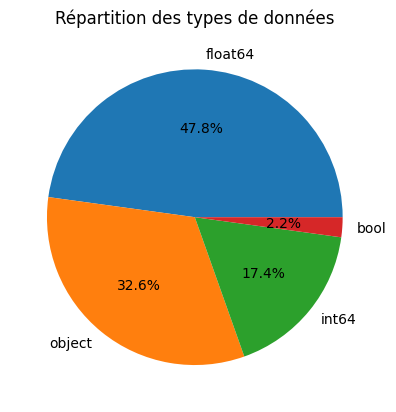

In [295]:
# Répartition du type de variable
compteur_type_variable(df_data_brut, True, True, True)

## <span style='background:green'>Nom et description des features</span>

Voici la définition de chaque variable :

1. **OSEBuildingID**: Identifiant unique attribué à chaque propriété couverte par l'ordonnance de benchmarking de Seattle à des fins de suivi et d'identification.

2. **DataYear**: Année civile (janvier-décembre) représentée par chaque enregistrement de données.

3. **BuildingType**: Classification des types de bâtiments de la ville de Seattle.

4. **PrimaryPropertyType**: L'utilisation principale d'une propriété (par exemple, bureau, magasin de détail). L'utilisation principale est définie comme une fonction qui représente plus de 50 % d'une propriété. Il s'agit du champ "Type de Propriété" calculé par l'EPA dans le Gestionnaire de Portefeuille.

5. **PropertyName**: Nom officiel ou courant de la propriété tel qu'indiqué dans le Gestionnaire de Portefeuille de l'EPA.

6. **Address**: Adresse de la propriété.

7. **City**: Ville de la propriété.

8. **State**: État de la propriété.

9.  **ZipCode**: Code postal de la propriété.

10. **TaxParcelIdentificationNumber**: Numéro d'identification de la parcelle du comté de King de la propriété.

11. **CouncilDistrictCode**: Code du district du conseil de la ville de Seattle de la propriété.

12. **Neighborhood**: Zone de voisinage de la propriété définie par le Département des Quartiers de la Ville de Seattle.

13. **Latitude**: Latitude de la propriété.

14. **Longitude**: Longitude de la propriété.

15. **YearBuilt**: Année de construction d'une propriété ou de sa rénovation complète.

16. **NumberofBuildings**: Nombre de bâtiments inclus dans le rapport de la propriété. Dans les cas où une propriété est signalée comme un campus, plusieurs bâtiments peuvent être inclus dans un seul rapport.

17. **NumberofFloors**: Nombre d'étages déclarés auprès de Agence de la protection environnemental des USA (EPA).

18. **PropertyGFATotal**: Surface brute totale (mesurées entre les murs extérieurs) du bâtiment et du parking.

19. **PropertyGFAParking**: Espace total en pieds carrés (ft²) de tous types de stationnement (entièrement fermé, partiellement fermé et ouvert).

20. **PropertyGFABuilding(s)**: Espace total en pieds carrés (ft²) entre les surfaces extérieures des murs d'enceinte d'un bâtiment. Cela inclut toutes les zones à l'intérieur du ou des bâtiments, telles que l'espace du locataire, les espaces communs, les cages d'escalier, les sous-sols, le stockage, etc.

21. **ListOfAllPropertyUseTypes**: Toutes les utilisations de propriété rapportées auprès de l'Agence de la protection environnemental des USA (EPA).

22. **LargestPropertyUseType**: La plus grande utilisation d'une propriété (par exemple, un bureau, un magasin de détail) en termes de surface brute (GFA).

23. **LargestPropertyUseTypeGFA**: La surface brute (GFA) de la plus grande utilisation de la propriété.

24. **SecondLargestPropertyUseType**: La deuxième plus grande utilisation d'une propriété (par exemple, un bureau, un magasin de détail) en termes de surface brute (GFA).

25. **SecondLargestPropertyUseTypeGFA**: La surface brute (GFA) de la deuxième plus grande utilisation de la propriété.

26. **ThirdLargestPropertyUseType**: La troisième plus grande utilisation d'une propriété (par exemple, un bureau, un magasin de détail) en termes de surface brute (GFA).

27. **ThirdLargestPropertyUseTypeGFA**: La surface brute (GFA) de la troisième plus grande utilisation de la propriété.

28. **YearsENERGYSTARCertified**: Années où la propriété a reçu la certification ENERGY STAR.

29. **ENERGYSTARScore**: Un indice calculé par l'EPA de 1 à 100 qui évalue les performances énergétiques globales d'une propriété, basé sur des données nationales pour corriger les différences entre le climat, les utilisations des bâtiments et les opérations. Un score de 50 représente la médiane nationale.

30. **SiteEUI(kBtu/sf)**: L'intensité d'utilisation d'énergie (EUI) du site, exprimeé en kBtu/ft².

31. **SiteEUIWN(kBtu/sf)**: L'EUI sur le site normalisée par les conditions météorologiques (WN). L'utilisation d'énergie du site WN est l'utilisation d'énergie du site que la propriété aurait consommée au cours de conditions météorologiques moyennes sur 30 ans. Exprimé en kBtu/ft².

32. **SourceEUI(kBtu/sf)**: L'EUI provenant de la source d'une propriété divisée par sa surface brute. L'utilisation d'énergie provenant de la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes de génération, de transmission et de distribution. Exprimé en kBtu/ft².

33. **SourceEUIWN(kBtu/sf)**: L'EUI provenant de la source normalisée par les conditions météorologiques (WN). L'utilisation d'énergie provenant de la source WN est l'énergie provenant de la source que la propriété aurait consommée au cours de conditions météorologiques moyennes sur 30 ans. en kBtu/ft².

34. **SiteEnergyUse(kBtu)**: La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie. Exprimée en kBtu. 

35. **SiteEnergyUseWN(kBtu)**: La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie, ajustée à ce que la propriété aurait consommé au cours des conditions météorologiques moyennes sur 30 ans.  Exprimée en kBtu.

36. **SteamUse(kBtu)**: La quantité annuelle de vapeur de district consommée par la propriété sur place. Exprimée en kBtu.

37. **Electricity(kWh)**: La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes d'énergie renouvelable sur place, exprimée en kilowattheures (kWh).

38. **Electricity(kBtu)**: La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes d'énergie renouvelable sur place, exprimée en kBtu.

39. **NaturalGas(therms)**: La quantité annuelle de gaz naturel fourni par l'entreprise de services publics consommée par la propriété, mesurée en therms.

40. **NaturalGas(kBtu)**: La quantité annuelle de gaz naturel fourni par l'entreprise de services publics consommée par la propriété, mesurée en kBtu.

41. **DefaultData**: La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété. Exprimé en booléen. 

42. **Comments**: Commentaires d'un propriétaire ou d'un agent immobilier pour fournir un contexte sur l'utilisation d'énergie du bâtiment.

43. **ComplianceStatus**: Indique si une propriété a satisfait aux exigences de benchmarking énergétique pour l'année de déclaration en cours.

44. **Outlier**: Indique si une propriété est un écart élevé ou faible (O/N).

45. **TotalGHGEmissions**: La quantité totale d'émissions de gaz à effet de serre, y compris le CO2, le méthane et les gaz d'oxyde nitreux, rejetée dans l'atmosphère en raison de la consommation d'énergie de la propriété, mesurée en tonnes métriques d'équivalent de dioxyde de carbone (tCO2e). <br><br>*Ce calcul utilise un facteur d'émissions de gaz à effet de serre du portefeuille de ressources de Seattle City Light. <br>Le facteur d'émissions de CO2e de 52,44 lb/MWh de Seattle City Light jusqu'à ce que le facteur de 2016 soit disponible. <br>Le facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu. <br>Le facteur de gaz est fourni par l'EPA Portfolio Manager = 53,11 kg CO2e/MBtu*.

46. **GHGEmissionsIntensity**: Les émissions totales de gaz à effet de serre divisées par la superficie brute de la propriété, mesurée en kg CO2e/ft². <br><br>*Ce calcul utilise un facteur d'émissions de gaz à effet de serre du portefeuille de ressources de Seattle City Light.*

*Rappel conversion unitées Anglo-Saxonne / Internationales:*
 
1 ft (pied) = 0,305 m<br>
1 m = 3,281 ft

1 ft² = 0,093 m²<br>
1 m² = 10,764 ft²

1 kBtu (kilobritish thermal units) = 0,293 kWh<br>
1 kWh = 3,412 kBtu

1 therm (conso de gaz) = 100 kBtu = 29,3 kWh<br>

1 lb (livre) = 0,454 kg<br>
1 kg = 2,205 lb (livre)

facteur d'émissions de CO2e (Seattle City Light/2015) = 52,44 lb/MWh = 23,78 kg/MWh (kg/mégawattheure)<br>
Le facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu = 77,257 kg CO2e/MMBtu = 0,263 kg CO2e/kWh
<br><br>

*Rappel Acronymes administratifs:*

**GFA** = Gross Floor Area = Surface hors oeuvre brute : somme des surfaces de chaque niveau, des surfaces des toitures-terrasses, des balcons ou loggias et des surfaces non closes situées au rez-de-chaussée, y compris l’épaisseur des murs et des cloisons. 

**EPA** = Environmental Protection Agency = Agence de la protection environnemental des USA : agence qui a lancé le programme 'Energy STAR' en 1992.

**EUI** = Energy Use Intensity = Intensité d'utilisation d'énergie : mesure qui permet d'évaluer l'efficacité énergétique d'un bâtiment ou d'une propriété. Elle est calculée avec l'utilisation d'énergie du site d'une propriété divisée par sa surface brute. L'utilisation d'énergie du site est la quantité annuelle de toute l'énergie consommée par la propriété sur place, telle que rapportée sur les factures d'utilité. L'EUI du site est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré, soit en kBtu/pied².

## <span style='background:green'>Résumé des données</span>

Quantitatives

In [296]:
# Résumé des variables quantitatives
df_data_brut.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.00000,3376.0,3360.00000,3376.00000,3376.00000,3376.00000,3376.00000,3368.00000,3376.00000,3.37600e+03,3376.00000,3.37600e+03,3.35600e+03,1679.00000,596.00000,2533.00000,3369.00000,3370.00000,3367.00000,3367.00000,3.37100e+03,3.37000e+03,3.36700e+03,3.36700e+03,3.36700e+03,3.36700e+03,3.36700e+03,0.0,3367.00000,3367.00000
mean,21208.99111,2016.0,98116.94911,4.43928,47.62403,-122.33480,1968.57316,1.10689,4.70912,9.48335e+04,8001.52607,8.68320e+04,7.91776e+04,28444.07582,11738.67517,67.91867,54.73212,57.03380,134.23285,137.78393,5.40367e+06,5.27673e+06,2.74596e+05,1.08664e+06,3.70761e+06,1.36850e+04,1.36850e+06,NaN,119.72397,1.17592
std,12223.75701,0.0,18.61520,2.12063,0.04776,0.02720,33.08816,2.10840,5.49446,2.18838e+05,32326.72393,2.07940e+05,2.01703e+05,54392.91793,29331.19929,26.87327,56.27312,57.16333,139.28755,139.10981,2.16106e+07,1.59388e+07,3.91217e+06,4.35248e+06,1.48507e+07,6.70978e+04,6.70978e+06,NaN,538.83223,1.82145
min,1.00000,2016.0,98006.00000,1.00000,47.49917,-122.41425,1900.00000,0.00000,0.00000,1.12850e+04,0.00000,3.63600e+03,5.65600e+03,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,-2.10000,0.00000e+00,0.00000e+00,0.00000e+00,-3.38268e+04,-1.15417e+05,0.00000e+00,0.00000e+00,NaN,-0.80000,-0.02000
25%,19990.75000,2016.0,98105.00000,3.00000,47.59986,-122.35066,1948.00000,1.00000,2.00000,2.84870e+04,0.00000,2.77560e+04,2.50948e+04,5000.00000,2239.00000,53.00000,27.90000,29.40000,74.70000,78.40000,9.25129e+05,9.70182e+05,0.00000e+00,1.87423e+05,6.39487e+05,0.00000e+00,0.00000e+00,NaN,9.49500,0.21000
50%,23112.00000,2016.0,98115.00000,4.00000,47.61867,-122.33249,1975.00000,1.00000,4.00000,4.41750e+04,0.00000,4.32160e+04,3.98940e+04,10664.00000,5043.00000,75.00000,38.60000,40.90000,96.20000,101.10000,1.80375e+06,1.90445e+06,0.00000e+00,3.45130e+05,1.17758e+06,3.23754e+03,3.23754e+05,NaN,33.92000,0.61000
75%,25994.25000,2016.0,98122.00000,7.00000,47.65712,-122.31941,1997.00000,1.00000,5.00000,9.09920e+04,0.00000,8.42762e+04,7.62002e+04,26640.00000,10138.75000,90.00000,60.40000,64.27500,143.89999,148.35000,4.22246e+06,4.38143e+06,0.00000e+00,8.29318e+05,2.82963e+06,1.18903e+04,1.18903e+06,NaN,93.94000,1.37000
max,50226.00000,2016.0,98272.00000,7.00000,47.73387,-122.22097,2015.00000,111.00000,99.00000,9.32016e+06,512608.00000,9.32016e+06,9.32016e+06,686750.00000,459748.00000,100.00000,834.40002,834.40002,2620.00000,2620.00000,8.73924e+08,4.71614e+08,1.34943e+08,1.92577e+08,6.57074e+08,2.97909e+06,2.97909e+08,NaN,16870.98000,34.09000


Qualitatives

In [297]:
# Résumé des variables qualitatives
df_data_brut.describe(exclude=[np.number])

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier
count,3376,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,119,3376,3376,32
unique,8,24,3362,3354,1,1,3268,19,466,56,50,44,65,2,4,2
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,1625049001,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,2016,False,Compliant,Low outlier
freq,1460,987,3,4,3376,3376,8,573,866,1667,976,110,14,3263,3211,23


## <span style='background:green'>Valeurs manquantes</span>

Valeurs manquantes (Nan) : 19952 / 155296 données (12.85 %)
26 / 46 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
SiteEnergyUse(kBtu),5,0.150000
SiteEUIWN(kBtu/sf),6,0.180000
SiteEnergyUseWN(kBtu),6,0.180000
SiteEUI(kBtu/sf),7,0.210000
NumberofBuildings,8,0.240000
NaturalGas(kBtu),9,0.270000
NaturalGas(therms),9,0.270000
Electricity(kBtu),9,0.270000
Electricity(kWh),9,0.270000
SteamUse(kBtu),9,0.270000


26 / 46 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


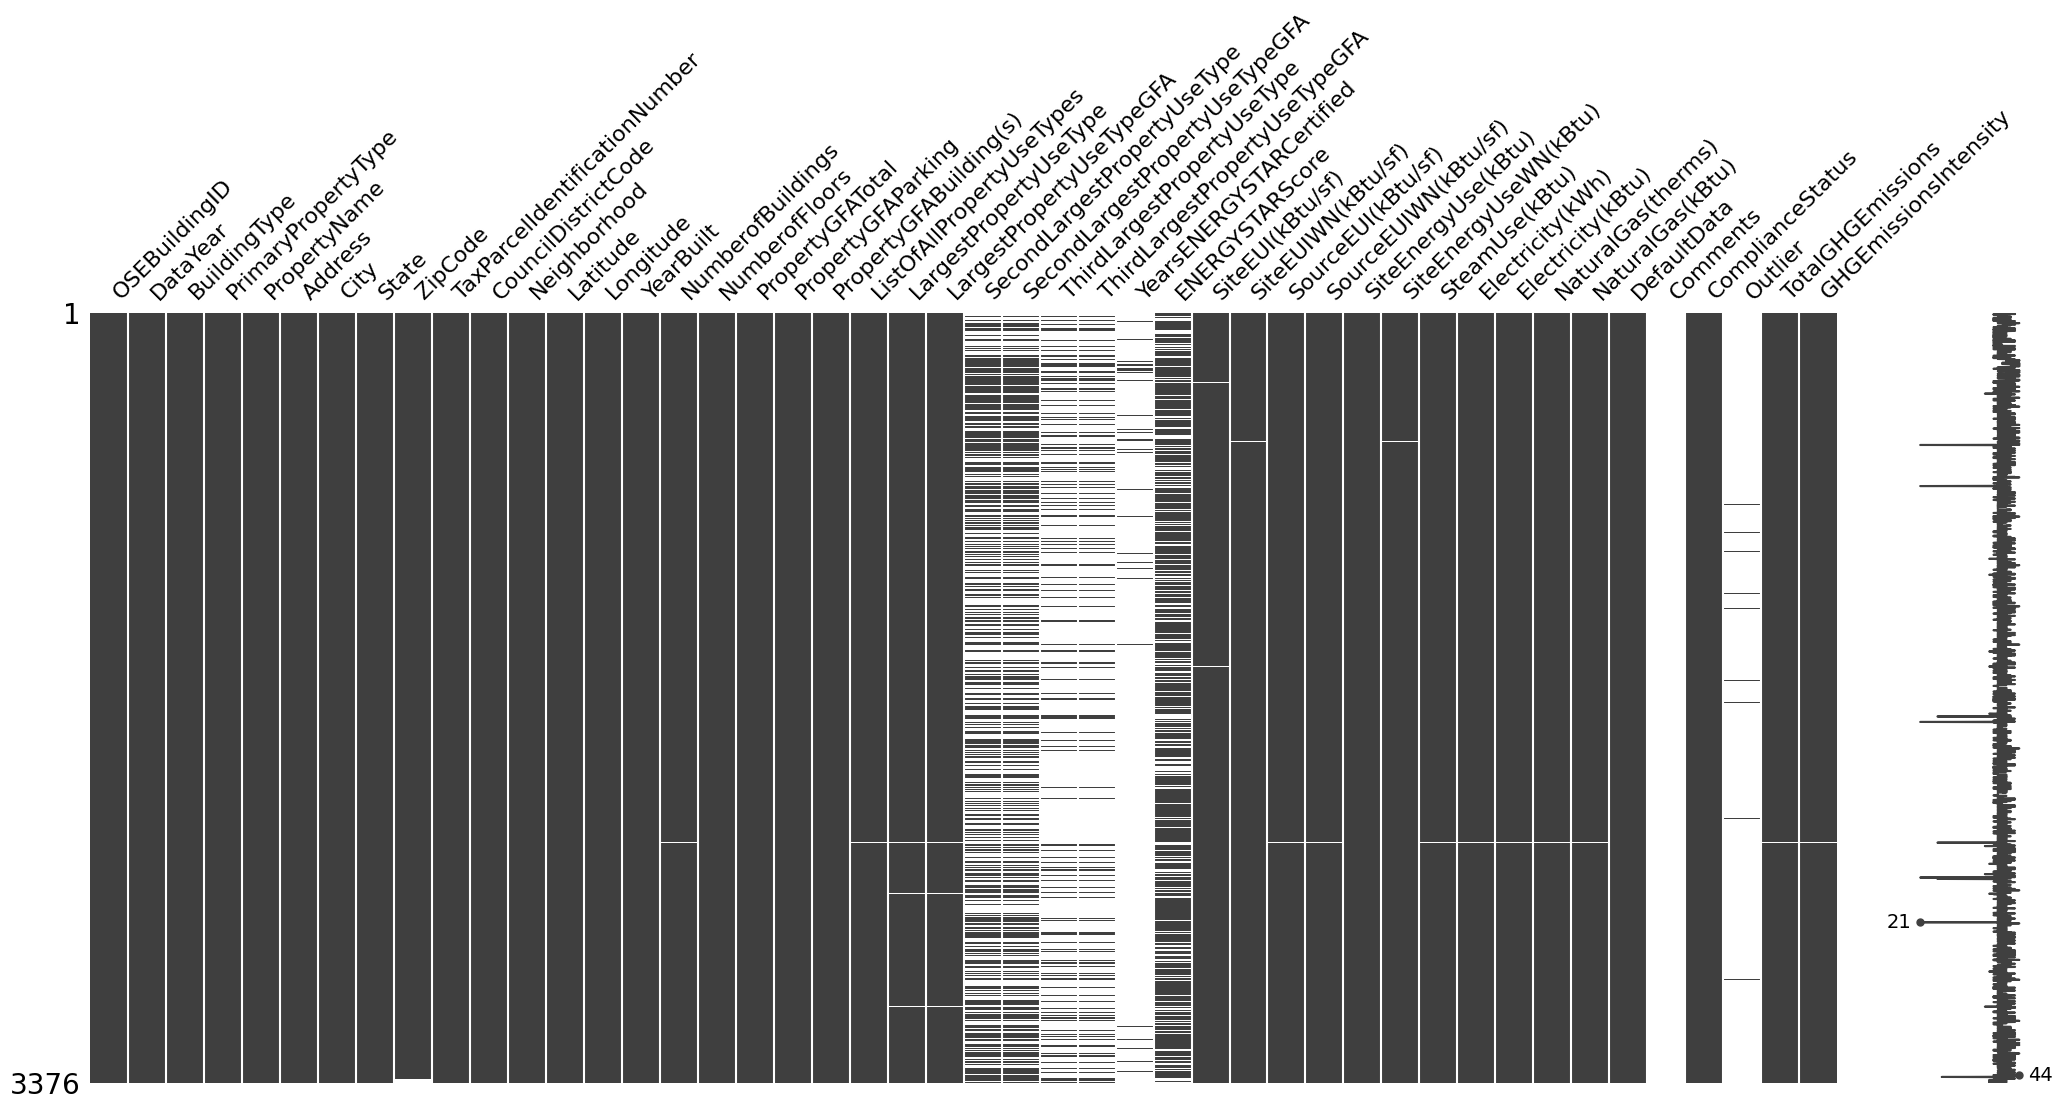

In [298]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_brut, True, True)

## <span style='background:green'>Doublons</span>

In [299]:
# Detection des doublons sur la variable du code
first = detect_doublon(df_data_brut, 'OSEBuildingID', 'first')

Doublons détecté(s) avec "first" sur "OSEBuildingID" : 0


___
**Bilan sur le jeu de données '2016_Building_Energy_Benchmarking.csv'**: 
___
-   Le jeu de données contient **3_376 lignes et 46 colonnes**.
<br><br>
- Le dataset contient des informations sur les batiments : 
  - **administratif** : type de bâtiment, types de commerce installés 
  - **géographique** : nom et localisation du bâtiment, type de voisinage
  - **temporelle** : date de construction du bâtiment, de la mesure
  - **structurelle** : superficie (avec et sans parking), nombre de batiments séparés, nombre d'étage, superficie par commerce
  - **qualité énergétique** : ENERGY STAR Score et sa date d'obtention
  - **quantité énergétique** : quantité d'énergie, normalisé par la météo, ratio énergie/superficie, vapeur, électricié, gaz
  - **émissions** : quantité d'émission de gaz à effet de serre, ration émission/superficie
<br><br>
- type de données :
  - **47,8% de nombre décimaux numérique** : 
  - **32,6% de texte**
  - 17,7% d'entier numériques
  - 2,2% de booléen
<br><br>
-   valeurs manquantes : 
    -   19_952  de NaN pour 155_296  observations (**12.85 %**).
    -   26 / 46 colonnes concernées
<br><br>
-   **Pas de doublons** sur la col 'OSEBuildingID'.
<br><br><br>

# <span style='background:blue'>Etape 2 : Nettoyage des données</span>
___

## <span style='background:green'>1/ Filtrage par taux de remplissage</span>

Nous identifions les colonnes qui présentent un taux de valeurs manquantes (NaN) > 50%. 

In [300]:
# Seuil_NaN
seuil_nan = 50

# Affichage graphique des NaN
df_Nan_par_ligne, df_to_supp = filtre_nan_par_seuil(df_data_brut, seuil_nan, False)

# Affichage
print("Voici les colonnes qui vont être supprimées: ")
display(df_to_supp)

Il y a 7 colonnes > 50 % de NaN
Voici les colonnes qui vont être supprimées: 


,nombre,pourcent
SecondLargestPropertyUseTypeGFA,1697.0,50.3
SecondLargestPropertyUseType,1697.0,50.3
ThirdLargestPropertyUseTypeGFA,2780.0,82.3
ThirdLargestPropertyUseType,2780.0,82.3
YearsENERGYSTARCertified,3257.0,96.5
Outlier,3344.0,99.1
Comments,3376.0,100.0


Nous allons supprimer toutes ces features car il y a trop de valeurs manquantes pour parvenir à imputer des valeurs assez fiables. Une exception tout de même pour la feature "Outlier" qui, malgré son faible taux de remplissage, peut nous permettre d'avoir des informations intérressantes pour exclure les quelques outliers du dataset. Nous conservons cet feature. 

In [301]:
# Suppression de la ligne "Outlier" des features à effacer
df_to_supp = df_to_supp.drop("Outlier", axis=0)

# Suppression des features sélectionnées
df_data_clean_nan = df_data_brut.drop(columns=df_to_supp.index)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_nan, "df_data_clean_nan", "des nan", 2)

Voici l'aspect de 'df_data_clean_nan' après nettoyage des nan


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,1.15651e+06,3946027.0,12764.52930,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,9.50425e+05,3242851.0,51450.81641,5145082.0,False,Compliant,NaN,295.86,2.86


3376 ligne(s) x 40 colonne(s)



## <span style='background:green'>2/ Suppression features redondantes</span>

### Liste des utilisation du batiment

Certaines features dans le dataset sont des features redondantes. C'est le cas par exemple de la feature qui liste les utilisations du bâtiment et qui est repris dans les features de chaque utilisation du bâtiment. 

Voici un échantillon pour preuve :

In [302]:
# Liste des colonnes sélectionnées
category_col = ["ListOfAllPropertyUseTypes", "LargestPropertyUseType"]

# Afficher un échantillon (sans NaN)
df_data_clean_nan[df_data_clean_nan[category_col].notnull().any(axis=1)][category_col].sample(5)

,ListOfAllPropertyUseTypes,LargestPropertyUseType
3063,"Office, Refrigerated Warehouse",Refrigerated Warehouse
2267,"Multifamily Housing, Parking",Multifamily Housing
2746,Multifamily Housing,Multifamily Housing
1514,Retail Store,Retail Store
1093,"Office, Parking",Office


Manifestement, la première feature comprend les élements de la deuxième mais elle en contient d'autres également. Nous vérifions le taux de remplissage de ces features :

In [303]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_nan[category_col], True, False)

Valeurs manquantes (Nan) : 29 / 6752 données (0.43 %)
2 / 2 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
ListOfAllPropertyUseTypes,9,0.270000
LargestPropertyUseType,20,0.590000


Dans le doute, nous allons garder ces features en l'état car nous ne savons pas laquelle possèdent le plus d'information pertinente. 

### Quantité d'énergie

Certaines features dans le dataset sont des features redondantes. C'est le cas par exemple des features qui indiquent la quantité d'énergie dans différentes unités. 

Voici un échantillon pour preuve :

In [304]:
# Liste des features sélectionnées
category_col = ["Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(therms)", "NaturalGas(kBtu)"]

# Afficher le début (sans NaN)
df_data_clean_nan[df_data_clean_nan[category_col].notnull().any(axis=1)][category_col].head(3)

,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu)
0,1.15651e+06,3946027.0,12764.52930,1276453.0
1,9.50425e+05,3242851.0,51450.81641,5145082.0
2,1.45154e+07,49526664.0,14938.00000,1493800.0


Sachant que:<br>
1 kBtu = 0,293 kWh => ALORS 3_946_027 kBtu = 1_156_185 kWh<br>
**Donc le feature "Electricity(kBtu)" est une conversion de la feature "Electricity(kWh)"**

Sachant que:<br>
1 therm = 100 kBtu => ALORS 12_764.52 therm = 1_276_452 kWh<br>
**Donc le feature "NaturalGas(kBtu)" est une conversion de la feature "NaturalGas(therms)"**

Si nous regardons le taux de remplissage de ces 4 features, nous pouvons constater qu'elles sont toutes les 4 remplies de façon similaire. Ce qui suppose que chacune d'elle contient les mêmes données, qui sont donc redondantes.

In [305]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_nan[category_col], True, False)

Valeurs manquantes (Nan) : 36 / 13504 données (0.27 %)
4 / 4 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
Electricity(kWh),9,0.270000
Electricity(kBtu),9,0.270000
NaturalGas(therms),9,0.270000
NaturalGas(kBtu),9,0.270000



Dans un soucis d'harmonisation des unités de quantité d'énergie du dataset (en kBtu), nous supprimons les features qui ne sont pas en kBtu.

In [306]:
# Suppression des features redondantes
df_data_clean_tampon = df_data_clean_nan.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

### Localisation

Les features "Address", "TaxParcelIdentificationNumber", "Latitude" et "Longitude" sont des features qui permettent de localiser le batiment.

Voici un échantillon pour preuve :

In [307]:
# Liste des features sélectionnées
category_col = ["Address", "TaxParcelIdentificationNumber", "Latitude", "Longitude"]

# Afficher le début (sans NaN)
df_data_clean_tampon[df_data_clean_tampon[category_col].notnull().any(axis=1)][category_col].head(3)

,Address,TaxParcelIdentificationNumber,Latitude,Longitude
0,405 Olive way,0659000030,47.61220,-122.33799
1,724 Pine street,0659000220,47.61317,-122.33393
2,1900 5th Avenue,0659000475,47.61393,-122.33810


La simple connaissance de la latitude et de la longitude suffit pour localiser correctement le bâtiment. L'adresse et le numéro de parcelle (numéro généré à partir de différents informations telles que le canton, la zone géographique, etc) ne sont donc pas nécessaires. 

Si nous regardons le taux de remplissage de ces 4 features, nous constatons qu'elles sont toutes les 4 entièrement remplies. Ce qui suppose que chacune d'elle contiennent les mêmes données, qui sont donc redondantes.

In [308]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_tampon[category_col], True, False)

Valeurs manquantes (Nan) : 0 / 13504 données (0.0 %)
0 / 4 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes


Nous supprimons donc les features "Address" et "TaxParcelIdentificationNumber". 

In [309]:
# Suppression des features redondantes
df_data_clean_redondant = df_data_clean_tampon.drop(columns=["Address", "TaxParcelIdentificationNumber"])

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_redondant, "df_data_clean_redondant", "des features redondantes", 2)

Voici l'aspect de 'df_data_clean_redondant' après nettoyage des features redondantes


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,City,State,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,Seattle,WA,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,Seattle,WA,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,False,Compliant,NaN,295.86,2.86


3376 ligne(s) x 36 colonne(s)



## <span style='background:green'>3/ Suppression features inutiles</span>

### Année de mesure, ville, code postal et état

Nous remarquons que 3 features ne présentent chacun qu'une seule valeur avec la totalité du dataset

In [310]:
# Résumé d'une variable quantitative
df_data_clean_redondant[["DataYear"]].describe()

,DataYear
count,3376.0
mean,2016.0
std,0.0
min,2016.0
25%,2016.0
50%,2016.0
75%,2016.0
max,2016.0


In [311]:
# Résumé de variables qualitatives
df_data_clean_redondant[["City", "State"]].describe()

,City,State
count,3376,3376
unique,1,1
top,Seattle,WA
freq,3376,3376


Il n'est donc pas utile de garder ces features. Il suffit de se rappeler que tous les batiments sont dans la ville de Seattle dans l'état de Washington. Le code postal est également inutile pour la suite des traitements. Nous pouvons supprimer ces features. 

In [312]:
# Liste des features inutiles à supprimer
col_to_supp = ["DataYear", "City", "State", "ZipCode"]

# Suppression des features inutiles
df_data_clean_inutile = df_data_clean_redondant.drop(columns=col_to_supp)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_inutile, "df_data_clean_inutile", "des features inutiles", 2)

Voici l'aspect de 'df_data_clean_inutile' après nettoyage des features inutiles


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,False,Compliant,NaN,295.86,2.86


3376 ligne(s) x 32 colonne(s)



## <span style='background:green'>4/ Gestion des features de consommation d'énergie</span>

Nous devons nous passer des features en lien avec la consommation d'énergie du passé (à l'exception des features cibles de nos prédictions) car nous n'aurons pas ces données dans le futur (c'est tout le but de prédire la quantité d'énergie). 

Tout d'abord, nous devons vérifier que la feature de consommation d'énergie est bien remplie pour toutes les lignes du dataset. Observons les Nan sur cette feature :

In [313]:
# Nombre de Nan sur la feature 'SiteEnergyUse(kBtu)'
print("Voici les", df_data_clean_inutile['SiteEnergyUse(kBtu)'].isna().sum(), "Nan de cette feature :")

# Affichage des lignes avec des NaN
df_data_clean_inutile[df_data_clean_inutile['SiteEnergyUse(kBtu)'].isna()]

Voici les 5 Nan de cette feature :


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
578,773,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN,NaN
758,19798,Multifamily LR (1-4),Low-Rise Multifamily,SANDHURST APTS,4,NORTHEAST,47.68149,-122.26471,1977,NaN,3,33166,0,33166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN,NaN
1792,23437,Multifamily LR (1-4),Low-Rise Multifamily,MERCER CREST APT,7,MAGNOLIA / QUEEN ANNE,47.62479,-122.36364,1957,NaN,4,23636,0,23636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN,NaN
2474,25752,Multifamily LR (1-4),Low-Rise Multifamily,GRANVIEW APARTMENTS,6,NORTHWEST,47.69658,-122.34342,1989,NaN,4,29562,8531,21031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN,NaN
2670,26532,NonResidential,Mixed Use Property,KALBERG BUILDING,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN,NaN


Nous supprimons les lignes présentant des Nan pour la feature "SiteEnergyUse(kBtu)" car notre prédiction à venir doit être basée sur une mesure réelle et pas sur une imputation.

In [314]:
# Suppression des lignes avec des NaN
df_data_clean_energie = df_data_clean_inutile.dropna(subset=['SiteEnergyUse(kBtu)'])

# vérification de la dimension du df
print_nbr_ligne_col(df_data_clean_energie)

3371 ligne(s) x 32 colonne(s)




Avant de supprimer ces features, nous allons calculer la proportion de chaque source d'énergie (électricité, vapeur et gaz naturel) dans la consommation totale d'énergie. 

In [315]:
# Calcul de la proportion d'énergie provenant de l'électricité (bornée de 0 à 1)
df_data_clean_energie.loc[:, 'Electricity_Proportion'] = np.where(df_data_clean_energie['SiteEnergyUse(kBtu)'] == 0, 0, 
    (df_data_clean_energie['Electricity(kBtu)'] / df_data_clean_energie['SiteEnergyUse(kBtu)']).clip(0, 1))

# Calcul de la proportion d'énergie provenant de la vapeur (bornée de 0 à 1)
df_data_clean_energie.loc[:, 'SteamUse_Proportion'] = np.where(df_data_clean_energie['SiteEnergyUse(kBtu)'] == 0, 0, 
    (df_data_clean_energie['SteamUse(kBtu)'] / df_data_clean_energie['SiteEnergyUse(kBtu)']).clip(0, 1))

# Calcul de la proportion d'énergie provenant du gaz naturel (bornée de 0 à 1)
df_data_clean_energie.loc[:, 'NaturalGas_Proportion'] = np.where(df_data_clean_energie['SiteEnergyUse(kBtu)'] == 0, 0, 
    (df_data_clean_energie['NaturalGas(kBtu)'] / df_data_clean_energie['SiteEnergyUse(kBtu)']).clip(0, 1))

C:\Users\pierr\AppData\Local\Temp\ipykernel_348\405495750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean_energie.loc[:, 'Electricity_Proportion'] = np.where(df_data_clean_energie['SiteEnergyUse(kBtu)'] == 0, 0,
C:\Users\pierr\AppData\Local\Temp\ipykernel_348\405495750.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean_energie.loc[:, 'SteamUse_Proportion'] = np.where(df_data_clean_energie['SiteEnergyUse(kBtu)'] == 0, 0,
C:\Users\pierr\AppData\Local\Temp\ipykernel_348\4054957

Nous supprimons donc les features :
- SiteEUI(kBtu/sf)
- SiteEUIWN(kBtu/sf)
- SourceEUI(kBtu/sf)
- SourceEUIWN(kBtu/sf)
- SiteEnergyUseWN(kBtu)
- SteamUse(kBtu)
- Electricity(kBtu)
- NaturalGas(kBtu)
- GHGEmissionsIntensity

In [316]:
# Liste des features de consommation d'énergie et émmission de gaz à supprimer
col_to_supp = ["SiteEUI(kBtu/sf)", 
            "SiteEUIWN(kBtu/sf)", 
            "SourceEUI(kBtu/sf)", 
            "SourceEUIWN(kBtu/sf)", 
            "SiteEnergyUseWN(kBtu)", 
            "SteamUse(kBtu)",
            "Electricity(kBtu)",
            "NaturalGas(kBtu)",
            "GHGEmissionsIntensity"]

# Suppression des features inutiles
df_data_clean_conso = df_data_clean_energie.drop(columns=col_to_supp)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_conso, "df_data_clean_conso", "des consommations d'énergie", 2)

Voici l'aspect de 'df_data_clean_conso' après nettoyage des consommations d'énergie


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
0,1,NonResidential,Hotel,Mayflower park hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,7226362.5,False,Compliant,NaN,249.98,0.54606,0.2773,0.17664
1,2,NonResidential,Hotel,Paramount Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,8387933.0,False,Compliant,NaN,295.86,0.38661,0.0000,0.61339


3371 ligne(s) x 26 colonne(s)



## <span style='background:green'>5/ Conservation des batiments non destinés à l'habitation</span>

Notre mission ne concerne que les **bâtiments non destinés à l’habitation de la ville de Seattle**. Nous allons donc supprimer toutes les lignes qui sont des habitations dans la feature "BuildingType". 

Visualisons toutes les valeurs possible de cet feature :

In [317]:
df_data_clean_conso['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Nous détectons 3 types de bâtiment qui sont destinées à l'habitation :
- 'Multifamily MR (5-9)'
- 'Multifamily LR (1-4)'
- 'Multifamily HR (10+)'

Nous supprimons les lignes de ces habitation 'Multifamily'. 

In [318]:
# Filtrage bâtiment non habitation
df_data_clean_habitation = df_data_clean_conso[~df_data_clean_conso['BuildingType'].str.contains("Multifamily")]

# Valeurs restantes de "BuildingType"
df_data_clean_habitation['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

Nous avons bien conservé uniquement les batiments non destinés à l'habitation.

In [319]:
# Mise à jour des index
df_data_clean_habitation.reset_index(drop=True, inplace=True)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_habitation, "df_data_clean_habitation", "des habitations", 2)

Voici l'aspect de 'df_data_clean_habitation' après nettoyage des habitations


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
0,1,NonResidential,Hotel,Mayflower park hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,7226362.5,False,Compliant,NaN,249.98,0.54606,0.2773,0.17664
1,2,NonResidential,Hotel,Paramount Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,8387933.0,False,Compliant,NaN,295.86,0.38661,0.0000,0.61339


1666 ligne(s) x 26 colonne(s)



## <span style='background:green'>6/ Conservation des batiments non recencés en outlier</span>

La feature "outlier' nous indique les batiments qui peuvent être utile d'exclure pour éviter que leurs valeurs atypiques affectent nos calculs à venir. 

Visualisons toutes les valeurs possible de cet feature :

In [320]:
# Dataframe des lignes non nulle sur la feature "Outlier"
df_outlier_all = df_data_clean_habitation[df_data_clean_habitation["Outlier"].notnull()]

# Afficher les valeurs possibles
outlier_unique = df_outlier_all["Outlier"].unique()
display(outlier_unique)

# Affichage aperçu et dimension du dataframe
display(df_outlier_all)
print_nbr_ligne_col(df_outlier_all)

array(['High outlier', 'Low outlier'], dtype=object)

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
220,350,NonResidential,Large Office,Second And Spring Building,7,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,172842,25920,146922,"Data Center, Office, Parking",Office,99890.0,NaN,4.13995e+07,False,Non-Compliant,High outlier,362.66,0.96124,0.0,0.03876
378,539,NonResidential,Retail Store,University Center,4,NORTHEAST,47.66178,-122.31812,1987,1.0,2,69492,0,69492,Retail Store,Retail Store,69800.0,100.0,3.18963e+05,False,Non-Compliant,Low outlier,2.22,1.00000,0.0,0.00000
442,608,NonResidential,Large Office,411 1ST AVE S (ID608),2,DOWNTOWN,47.59878,-122.33458,1913,5.0,7,154159,0,154159,Office,Office,193154.0,100.0,1.11959e+07,False,Non-Compliant,Low outlier,29.43,0.14369,0.0,0.03064
507,704,NonResidential,Large Office,401 Elliott Ave West,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,1.0,4,129551,42500,87051,"Data Center, Office, Parking",Office,82273.0,1.0,2.71372e+07,False,Non-Compliant,High outlier,189.18,1.00000,0.0,0.00000
697,19967,SPS-District K-12,K-12 School,Queen Anne Gym,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1.0,1,35805,0,35805,K-12 School,K-12 School,35805.0,100.0,4.31472e+05,True,Error - Correct Default Data,Low outlier,11.54,0.57160,0.0,0.42840
776,20617,NonResidential,Retail Store,Seattle Habitat Store,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1.0,1,39900,0,39900,"Non-Refrigerated Warehouse, Retail Store",Retail Store,25000.0,100.0,1.45469e+05,True,Error - Correct Default Data,Low outlier,5.46,0.33688,0.0,0.66313
867,21315,NonResidential,Small- and Mid-Sized Office,1518 Fifith Ave,7,DOWNTOWN,47.61119,-122.33581,1903,1.0,3,57720,0,57720,Office,Office,25000.0,NaN,2.41055e+04,False,Non-Compliant,Low outlier,0.17,0.99998,0.0,0.00000
909,21474,NonResidential,Other,The Lusty Lady,7,DOWNTOWN,47.60711,-122.33886,1900,1.0,3,49760,0,49760,Other,Other,24019.0,NaN,4.42935e+04,False,Non-Compliant,Low outlier,0.31,1.00000,0.0,0.00000
1032,22830,NonResidential,Worship Facility,Freedom Church,1,SOUTHWEST,47.51709,-122.37797,1971,1.0,1,23772,0,23772,Worship Facility,Worship Facility,23772.0,100.0,1.00842e+05,False,Non-Compliant,Low outlier,0.70,1.00000,0.0,0.00000
1133,23912,NonResidential,Small- and Mid-Sized Office,1416 S Jackson,3,CENTRAL,47.59973,-122.31331,1947,1.0,1,45068,0,45068,Office,Office,45068.0,100.0,2.84857e+05,False,Non-Compliant,Low outlier,8.59,0.49774,0.0,0.50226


17 ligne(s) x 26 colonne(s)



Nous supprimons ces batiments qui sont spécifiés comme étant des outliers

In [321]:
# Filtrage bâtiment outlier
df_data_clean_outlier = df_data_clean_habitation[~df_data_clean_habitation['Outlier'].isin(outlier_unique)]

L'information contenue dans la feature "Outlier" ayant été traitée, nous supprimons cet feature qui est faiblement remplie.

In [322]:
# Suppression des features inutiles
df_data_clean_outlier = df_data_clean_outlier.drop(columns=["Outlier"])

# Mise à jour des index
df_data_clean_outlier.reset_index(drop=True, inplace=True)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_outlier, "df_data_clean_outlier", "des outliers", 2)

Voici l'aspect de 'df_data_clean_outlier' après nettoyage des outliers


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
0,1,NonResidential,Hotel,Mayflower park hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,7226362.5,False,Compliant,249.98,0.54606,0.2773,0.17664
1,2,NonResidential,Hotel,Paramount Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,8387933.0,False,Compliant,295.86,0.38661,0.0000,0.61339


1649 ligne(s) x 25 colonne(s)



## <span style='background:green'>7/ Imputation feature qualitative</span>

Le dataframe actuel ne comporte plus beaucoup de valeurs manquantes.

In [323]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_outlier, True, False)

Valeurs manquantes (Nan) : 574 / 41225 données (1.39 %)
3 / 25 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
LargestPropertyUseType,4,0.240000
LargestPropertyUseTypeGFA,4,0.240000
ENERGYSTARScore,566,34.320000


Nous remarquons qu'il n'y a que la feature "ENERGYSTARScore" pour laquelle de nombreuses lignes de bâtiment présentent des valeurs manquantes. Nous traiterons cet feature dans un second temps. 

Affichons d'abord le type de donnée des lignes de batiment qui présentent une valeur manquante sur d'autres features.

Puis affichons les lignes concernées par ces NaN. 

In [324]:
# Liste des features avec des Nan (hors "ENERGYSTARScore")
feature_nan_list = df_data_clean_outlier.columns[df_data_clean_outlier.isna().any()].tolist()

# Supprimer la colonne 'ENERGY' de la liste
feat_a_supprimer = 'ENERGYSTARScore'
feature_nan_list = [col for col in feature_nan_list if col != feat_a_supprimer]

# Répartition du type de variable
compteur_type_variable(df_data_clean_outlier[feature_nan_list], True, False, False)

# Affichage NaN (sans prendre en compte "ENERGYSTARScore")
lignes_avec_nan = affiche_nan_hors_energyscore(df_data_clean_outlier, feature_nan_list)

----------------------------------------------------------------------------------------------------
Type de variable pour chacune des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LargestPropertyUseType     1645 non-null   object 
 1   LargestPropertyUseTypeGFA  1645 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.9+ KB


None

 Voici 4 les lignes de bâtiment qui présentent des Nan, hors feature 'ENERGYSTARScore' :


,LargestPropertyUseType,LargestPropertyUseTypeGFA
346,NaN,NaN
814,NaN,NaN
1335,NaN,NaN
1352,NaN,NaN


Nous remarquons que seul la feature "LargestPropertyUseType" contient des données qualitatives. Nous avons vu précedement que la feature "ListOfAllPropertyUseTypes" présente les valeurs des 3 features de la famille de "LargestPropertyUseType".  

Affichons les valeurs de ces 2 features à l'endroit où il y a des NaN :

In [325]:
# Liste des features avec des Nan (hors "ENERGYSTARScore")
feature_usetype_list = ["ListOfAllPropertyUseTypes", "LargestPropertyUseType"]

# Création masque pour identifier les lignes avec NaN (hors feature spécifiée)
masque_nan = df_data_clean_outlier[feature_usetype_list].isna().any(axis=1)

# Appliquez le masque pour filtrer les lignes
lignes_nan_usetype = df_data_clean_outlier[masque_nan]

# Affichez les lignes avec NaN dans la colonne 'LargestPropertyUseType'
display(lignes_nan_usetype[feature_usetype_list])

,ListOfAllPropertyUseTypes,LargestPropertyUseType
346,"Fitness Center/Health Club/Gym, Office, Other ...",NaN
814,Hotel,NaN
1335,Office,NaN
1352,Restaurant,NaN


Nous pouvons implémenter les valeurs manquantes de la feature "LargestPropertyUseType" avec celle de la feature "ListOfAllPropertyUseTypes" puisqu'il n'y a qu'une seule valeur. A l'exception de la ligne 346 car il n'y a pas qu'une seule valeur (nous la supprimons). 

In [326]:
# Copie du dataframe
df_data_clean_usetype_nan = df_data_clean_outlier.copy()

# Suppression de la ligne 346
df_data_clean_usetype_nan.drop(346, inplace=True)

# Mise à jour des index
df_data_clean_usetype_nan.reset_index(drop=True, inplace=True)

# Remplacez NaN de 'LargestPropertyUseType' par valeur 'ListOfAllPropertyUseTypes'
df_data_clean_usetype_nan['LargestPropertyUseType'].fillna(df_data_clean_usetype_nan['ListOfAllPropertyUseTypes'], inplace=True)

Nous affichons à nouveau les lignes qui étaient concernées par les NaN (sauf "ENERGYSTARScore"). 

In [327]:
# Affichage NaN (sans prendre en compte "ENERGYSTARScore")
lignes_avec_nan = affiche_nan_hors_energyscore(df_data_clean_usetype_nan, feature_nan_list)

 Voici 3 les lignes de bâtiment qui présentent des Nan, hors feature 'ENERGYSTARScore' :


,LargestPropertyUseType,LargestPropertyUseTypeGFA
813,Hotel,NaN
1334,Office,NaN
1351,Restaurant,NaN


Nous remarquons que la feature "LargestPropertyUseType" est bien remplie. Nous pouvons supprimer cet feature de la liste des features présentant des Nan.

In [328]:
# Enlevez 'LargestPropertyUseType' de la liste
feature_nan_list.remove("LargestPropertyUseType")

# Affichez la liste mise à jour
print(feature_nan_list)

['LargestPropertyUseTypeGFA']


Nous supprimons la feature "ListOfAllPropertyUseTypes" du dataframe puisqu'elle ne nous apporte plus d'information utiles car elle est désormais redondantes avec la feature "LargestPropertyUseType". 

In [329]:
# Suppression des features sélectionnées
df_data_clean_usetype_nan = df_data_clean_usetype_nan.drop(columns="ListOfAllPropertyUseTypes")


Les NaN restantes ne concernent plus que des données quantitatives. 

In [330]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_usetype_nan, True, False)

Valeurs manquantes (Nan) : 568 / 39552 données (1.44 %)
2 / 24 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
LargestPropertyUseTypeGFA,3,0.180000
ENERGYSTARScore,565,34.280000


In [331]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_usetype_nan, "df_data_clean_usetype_nan", "des Nan des features qualitatifs", 2)

Voici l'aspect de 'df_data_clean_usetype_nan' après nettoyage des Nan des features qualitatifs


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
0,1,NonResidential,Hotel,Mayflower park hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,60.0,7226362.5,False,Compliant,249.98,0.54606,0.2773,0.17664
1,2,NonResidential,Hotel,Paramount Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,61.0,8387933.0,False,Compliant,295.86,0.38661,0.0000,0.61339


1648 ligne(s) x 24 colonne(s)



## <span style='background:green'>8/ Imputation features quantitatives</span>

Nous isolons les features quantitatives dans un dataframe de travail pour l'imputation. 

In [332]:
# Comptage du nombre de feature quantitatives
feat_quanti_list = df_data_clean_usetype_nan.select_dtypes(include=['int', 'float']).columns

# df de travail est une copie des features quantitatives du dataframe
df_travail = df_data_clean_usetype_nan[feat_quanti_list]

# Affichage dataframe des données quantitatives
display(df_travail.head(3))
print(df_travail.shape)

,OSEBuildingID,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
0,1,7,47.61220,-122.33799,1927,1.0,12,88434,0,88434,88434.0,60.0,7226362.5,249.98,0.54606,0.27730,0.17664
1,2,7,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,83880.0,61.0,8387933.0,295.86,0.38661,0.00000,0.61339
2,3,7,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,756493.0,43.0,72587024.0,2089.28,0.68231,0.29711,0.02058


(1648, 17)


### <span style='background:yellow; color:black'>a/ LargestPropertyUseTypeGFA</span>

Nous allons implémenter les NaN de cette feature présentant des Nan par des calculs de machine learning en utilisant l'algorithme KNN. 

Nous allons d'abord observer la distribution et les statitisques descriptives de cette feature avant l'imputation.

['LargestPropertyUseTypeGFA'] 



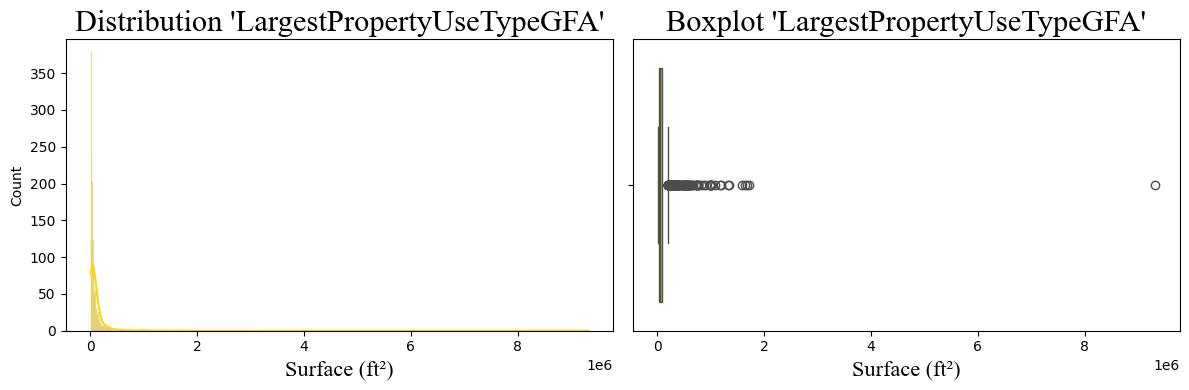

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,25649.0,99299.2,44078.0,92129.0,277968.6,2.8,23.18,739.5


In [333]:
# Liste des features avec des Nan
print(feature_nan_list, "\n")

# Affichage de la distribution des valeurs
plot_distribution(df_travail, feature_nan_list[0], colors_list[0], unit="Surface (ft²)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_travail, feature_nan_list[0])
display(df_stat)

Nous allons utiliser l'imputation par le KNNImputer.

Nous allons d'abord utiliser un GridSearch pour calculer le nombre de voisin optimal pour l'imputation KNN

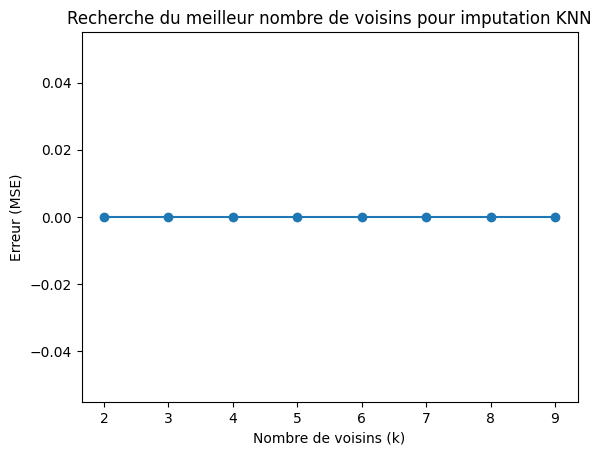

Le meilleur nombre de voisins est : 2


In [334]:
# Bornes du GridSearch
k_min, k_max = 2, 10

# Calcul du meilleur nombre de voisin pour l'imputation KNN
errors = determine_meilleur_voisin_knn(df_travail, k_min, k_max)

Nous réalisons donc l'imputation KNN avec le nombre optimal de voisin trouvés : 2

In [335]:
# Créez un objet d'imputation KNN (2 voisins proches, valeurs manquantes=NaN)
imputerKNN = KNNImputer(n_neighbors=2, missing_values=np.nan)

# Entraînez et applique le modèle d'imputation KNN 
df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df_travail[feature_nan_list]), columns=df_travail[feature_nan_list].columns)

Nous allons vérifier la distribution et les statitisques descriptives de la feature après l'imputation.

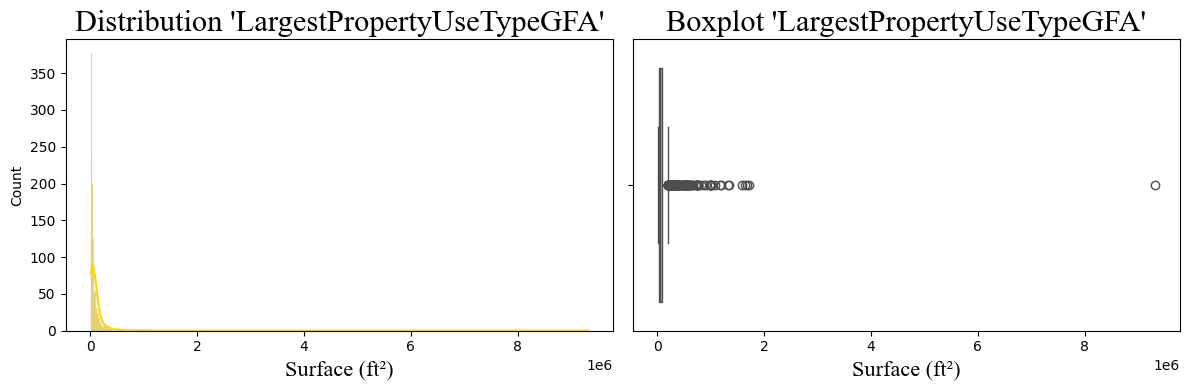

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,25680.5,99299.2,44126.5,92508.5,277715.5,2.8,23.2,740.8


In [336]:
# Affichage de la distribution des valeurs
plot_distribution(df_datas_imputed, feature_nan_list[0], colors_list[0], unit="Surface (ft²)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_datas_imputed, feature_nan_list[0])
display(df_stat)

La distribution de cette feature qui présentaient des NaN a été bien conservée suite à l'implémentation par KNN.

Vérifions les tailles des 2 dataframes (celui avec les NaN et celui avec les valeurs imputées)

In [337]:
# Affichage dataframe des données imputées
display(df_datas_imputed.head(3))
print(df_datas_imputed.shape)

,LargestPropertyUseTypeGFA
0,88434.0
1,83880.0
2,756493.0


(1648, 1)


In [338]:
# Affichage dataframe des données quantitatives
display(df_travail.head(3))
print(df_travail.shape)

,OSEBuildingID,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
0,1,7,47.61220,-122.33799,1927,1.0,12,88434,0,88434,88434.0,60.0,7226362.5,249.98,0.54606,0.27730,0.17664
1,2,7,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,83880.0,61.0,8387933.0,295.86,0.38661,0.00000,0.61339
2,3,7,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,756493.0,43.0,72587024.0,2089.28,0.68231,0.29711,0.02058


(1648, 17)


Les 2 dataframes présentent bien le même nombre de ligne, donc nous allons pouvoir remplacer les features du dataframe avec NaN par celui avec les  valeurs imputées.

In [339]:
# Remplacez features dans dataframe avec NaN par celles du dataframe imputé
df_travail.loc[:, feature_nan_list] = df_datas_imputed.loc[:, feature_nan_list]

Nous vérifions les NaN restant dans le dataframe d'imputation.

In [340]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_travail, True, False)

Valeurs manquantes (Nan) : 565 / 28016 données (2.02 %)
1 / 17 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
ENERGYSTARScore,565,34.280000


### <span style='background:yellow; color:black'>b/ ENERGYScore</span>


Nous réalisons l'imputation avec 3 méthodes pour pouvoir les comparer plus tard lors de l'analyse des corrélations si elles présentent des résultats d'imputation satisfaisants:
- Imputation par la médiane
- Imputation par l'algorithme KNN
- Imputation par algorithme iterative imputer

Nous allons d'abord observer la distribution et les statitisques descriptives des colonnes avant l'imputation.

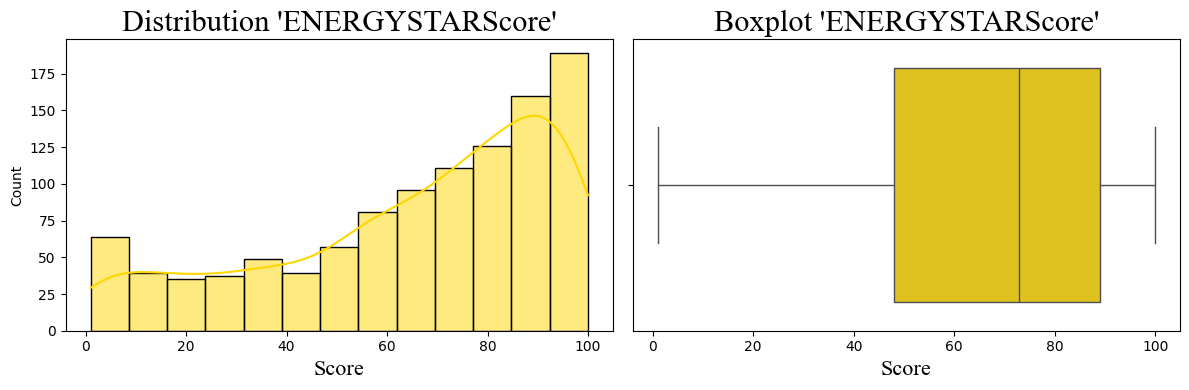

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,48.0,65.2,73.0,89.0,28.4,0.44,-0.77,-0.5


In [341]:
# Courbe
plot_distribution(df_travail, "ENERGYSTARScore", colors_list[0], unit="Score")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_travail, "ENERGYSTARScore")
display(df_stat)

#### Imputation par la médiane

Nous allons utiliser l'imputation par le Simple Imputer paramétrer sur la médiane.

In [342]:
# Créez un objet imputer pour l'imputation par la médiane
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Appliquez l'imputation sur un DataFrame
datas_imputed = imputer.fit_transform(df_travail)
df_datas_imputed = pd.DataFrame(datas_imputed, columns=df_travail.columns)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

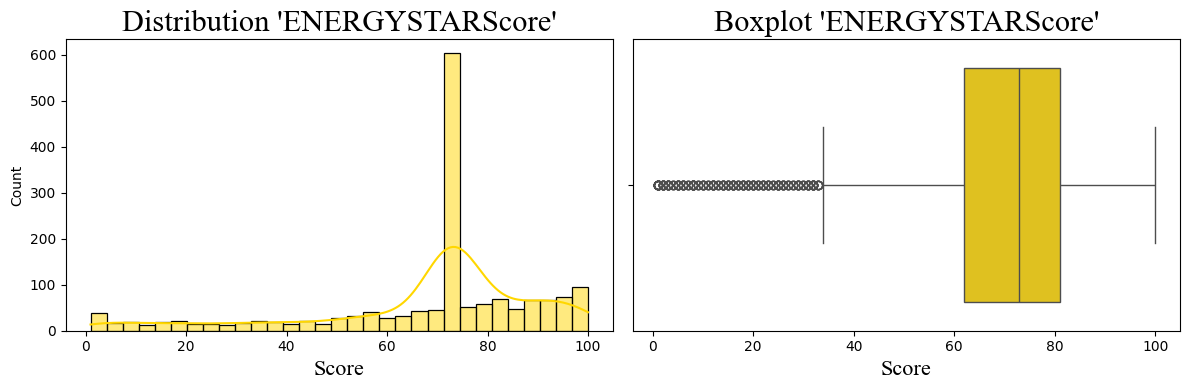

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,62.0,67.9,73.0,81.0,23.3,0.34,-1.25,1.1


In [343]:
# Courbe
plot_distribution(df_datas_imputed, "ENERGYSTARScore", colors_list[0], unit="Score")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_datas_imputed, "ENERGYSTARScore")
display(df_stat)

La distribution des données d'ENERGYSTARScore qui présentaient des NaN n'a pas été bien conservée suite à l'implémentation par la médiane. 

**Nous ne retenons par la méthode d'imputation par la médiane car les résultats sont de mauvaise qualité.**

#### Imputation par l'algorithme KNN

Nous allons utiliser l'imputation par le KNNImputer.

Nous allons d'abord utiliser un GridSearch pour calculer le nombre de voisin optimal pour l'imputation KNN

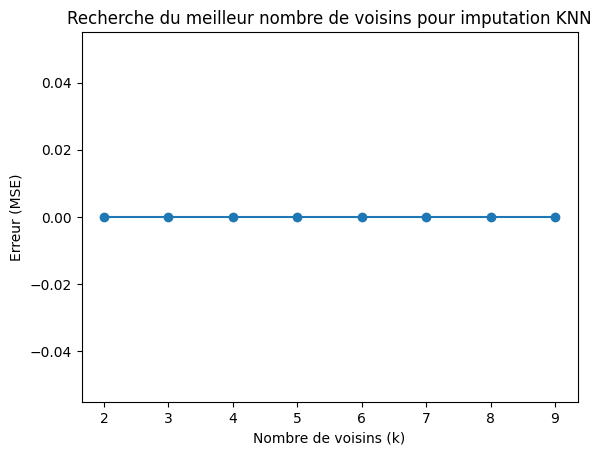

Le meilleur nombre de voisins est : 2


In [344]:
# Bornes du GridSearch
k_min, k_max = 2, 10

# Calcul du meilleur nombre de voisin pour l'imputation KNN
errors = determine_meilleur_voisin_knn(df_travail, k_min, k_max)

Nous réalisons donc l'imputation KNN avec le nombre optimal de voisin trouvés : 2

In [345]:
# Créez un objet d'imputation KNN (2 voisins proches, valeurs manquantes=NaN)
imputerKNN = KNNImputer(n_neighbors=2, missing_values=np.nan)

# Entraînez et applique le modèle d'imputation KNN 
df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df_travail), columns=df_travail.columns)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

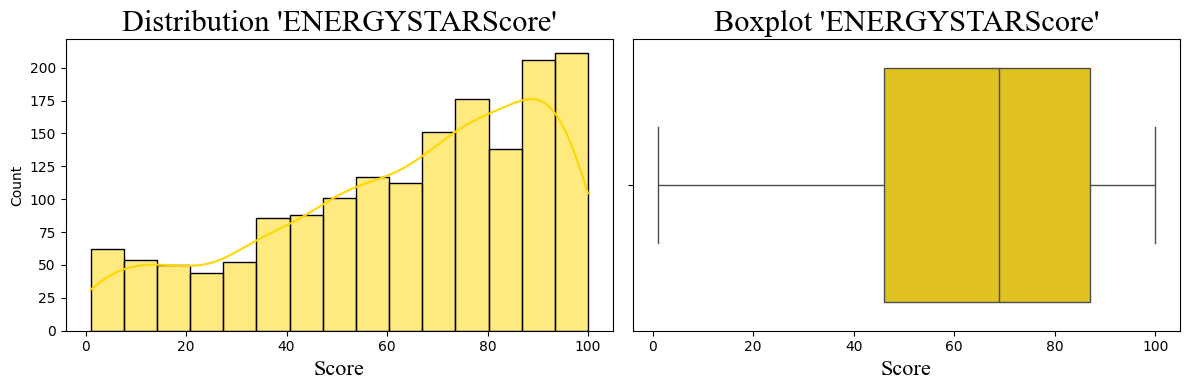

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,46.0,63.7,69.0,87.0,27.0,0.42,-0.64,-0.6


In [346]:
# Courbe
plot_distribution(df_datas_imputed, "ENERGYSTARScore", colors_list[0], unit="Score")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_datas_imputed, "ENERGYSTARScore")
display(df_stat)

La distribution des données d'ENERGYSTARScore qui présentaient des NaN a été bien conservée suite à l'implémentation par KNN.

Vérifions les tailles des 2 dataframes (celui avec les NaN et celui avec les valeurs imputées)

In [347]:
# Affichage dataframe des données d'ENERGYSTARScore imputées
print(df_datas_imputed.shape)

# Affichage dataframe des données quantitatives avec les NaN
print(df_travail.shape)

(1648, 17)
(1648, 17)


Les 2 dataframes présentent bien le même nombre de ligne, donc nous allons pouvoir ajouter une nouvelle feature dans le dataframe avec les valeurs imputées.

In [348]:
# Déterminer contenu et position de la nouvelle colonne
nouvelle_col = df_datas_imputed['ENERGYSTARScore'] 
position = df_travail.columns.get_loc('ENERGYSTARScore') + 1  

# Insertion de la nouvelle colonne
df_travail.insert(position, 'ENERGYSTARScore_KNN', nouvelle_col)

#### Vérification des taux de remplissage des features imputées

Nous vérifions les NaN restant dans le dataframe d'imputation.

In [349]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_travail, True, False)

Valeurs manquantes (Nan) : 565 / 29664 données (1.9 %)
1 / 18 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
ENERGYSTARScore,565,34.280000


Seul la feature "ENERGYSTARScore" présente toujours des NaN, ce qui est normal puisque nous avons créer une nouvelle feature avec les données imputées séparée. 

**Nous conservons cet feature avec des Nan pour pouvoir évaluer l'impact de l'imputation sur les corrélations.**

Nous avons imputé toutes les features quantitatives. Nous pouvons reintegrer ces features dans le dataframe des données nettoyées. 

In [350]:
# Copie de la dernière version du dataframe entier
df_data_clean_imputation = df_data_clean_usetype_nan.copy()

# Mise à jour des features quantitatives
df_data_clean_imputation[feat_quanti_list] = df_travail[feat_quanti_list]

# Insertion de la nouvelle feature des imputation KNN
nouvelle_col = df_travail['ENERGYSTARScore_KNN'] 
position = df_data_clean_imputation.columns.get_loc('ENERGYSTARScore') + 1  
df_data_clean_imputation.insert(position, 'ENERGYSTARScore_KNN', nouvelle_col)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_imputation, "df_data_clean_imputation", "des imputations", 2)

Voici l'aspect de 'df_data_clean_imputation' après nettoyage des imputations


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
0,1,NonResidential,Hotel,Mayflower park hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,60.0,60.0,7226362.5,False,Compliant,249.98,0.54606,0.2773,0.17664
1,2,NonResidential,Hotel,Paramount Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,61.0,61.0,8387933.0,False,Compliant,295.86,0.38661,0.0000,0.61339


1648 ligne(s) x 25 colonne(s)



## <span style='background:green'>9/ Transformation logarithmique des features cibles</span>

Nous devons prédire les émissions de CO2 et la consommation totale d’énergie. Pour cela nous identifions les 2 features cibles dans le dataset: 
- Emission de CO2 : **'TotalGHGEmissions'** exprimé en tonnes métriques d'équivalent de dioxyde de carbone (tCO2e)
<br><br>
- Consommation totale d’énergie : **'SiteEnergyUse(kBtu)'** exprimé en kBtu (unité thermique britannique)

### <span style='background:yellow; color:black'>a/ TotalGHGEmissions</span>

Nous appliquons le **test Shapiro-Wilk** pour vérifier si la distribution est normale. Pour cela, nous devons émettre les 2 hypothèses de ce test :

**Hypothèse nulle (H0) : la population est distribuée normalement selon la loi gaussienne.**

Hypothèse alternative (HA) : la population n'est pas distribuée normalement selon la loi gaussienne.

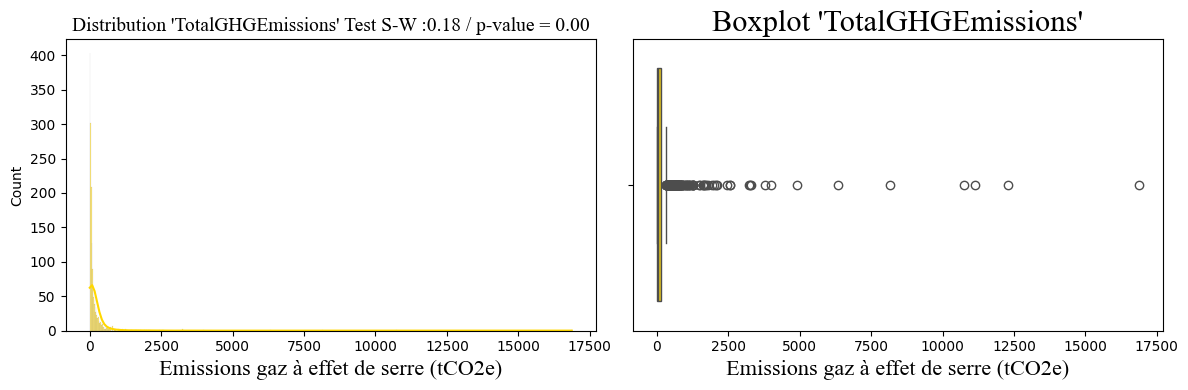

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,20.5,186.5,49.9,143.6,755.6,4.05,14.14,244.6


In [351]:
# Feature analysée
feature_analyzed = "TotalGHGEmissions"

# Histogramme distribution
plot_distribution(df_data_clean_imputation, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Emissions gaz à effet de serre (tCO2e)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_data_clean_imputation, feature_analyzed)
display(df_stat)

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Les données de cet feature cible ne sont pas distribuées normalement.**

Nous remarquons qu'il y a des outliers qui sont très éloignées de la moyenne et la médiane. Pour autant, ces valeurs semblent atypiques mais pas aberrantes. En effet, les relevés officiels de l'Agence de protection de l'environnement des États-Unis (Environmental Protection Agency, EPA) affichent une quantité d'émissions de gaz à effet de serre de l'ordre de 87_000 tCO2e pour le seul campus de l'université de Washington basée à Seattle en 2016. Notre plus grande valeur se situe aux alentours de 17_500 tCO2e soit environ 5 fois moins d'émission.<br><br>
**Toutes nos données d'émission de CO2 sont donc probables.** 

**Source:**<br>
[GHGEmissions of University of Washington Seattle Campus university in 2016 by EPA](https://ghgdata.epa.gov/ghgp/service/facilityDetail/2016?id=1002682&ds=E&et=&popup=true)

Nous allons donc conserver ces outliers pour la suite des traitements et nous transformons la distribution de cet feature cible en appliquant une transformation logarithmique en prenant soin d'utiliser la méthode Log(1+x) pour éviter la valeur infini pour les valeurs nulles (=0).

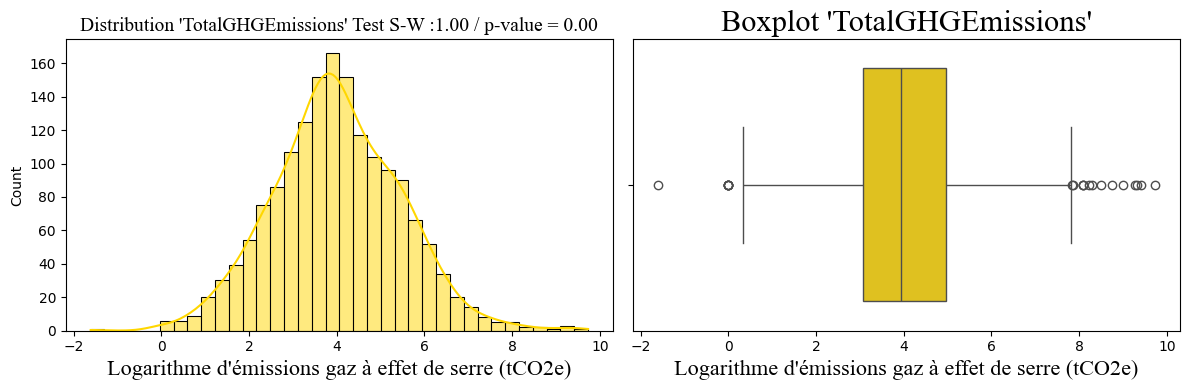

In [352]:
# Copie du dataframe
df_data_log = df_data_clean_imputation.copy()

# Transformation logarithmique (log(1+x))
df_data_log[feature_analyzed] = np.log1p(df_data_clean_imputation[feature_analyzed])

# Histogramme
plot_distribution(df_data_log, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Logarithme d'émissions gaz à effet de serre (tCO2e)")

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Les données de cet feature cible ne sont malgré tout pas distribuées normalement.**

### <span style='background:yellow; color:black'>b/ SiteEnergyUse(kBtu)</span>

Nous appliquons le **test Shapiro-Wilk** pour vérifier si la distribution est normale.

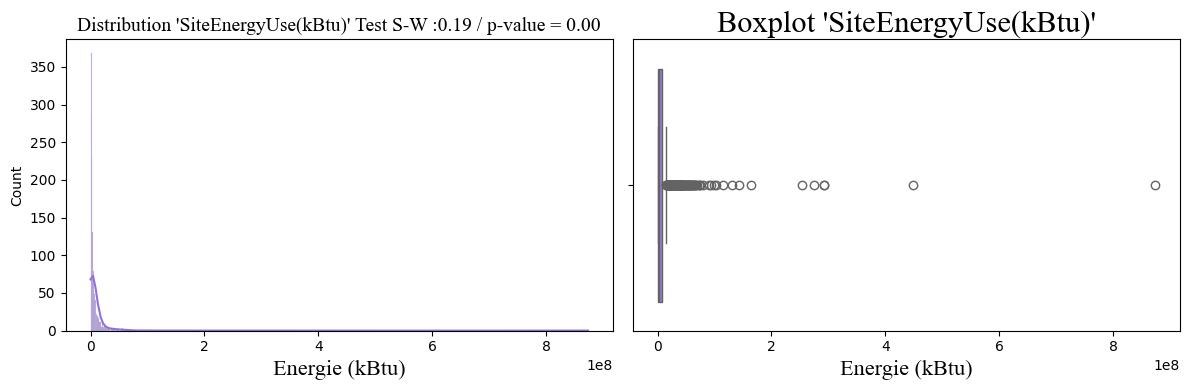

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,1251083.4,8476726.3,2582214.4,6928335.0,30375344.3,3.58,17.99,441.6


In [353]:
# Feature analysée
feature_analyzed = "SiteEnergyUse(kBtu)"

# Histogramme
plot_distribution(df_data_clean_imputation, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Energie (kBtu)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_data_clean_imputation, feature_analyzed)
display(df_stat)

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Les données de cet feature cible ne sont pas distribuées normalement.**

Nous remarquons qu'il y a des outliers qui sont très éloignées de la moyenne et la médiane. Pour autant, ces valeurs semblent atypiques mais pas aberrantes. En effet, le rapport d'analyse des consommations énergétiques des batiments de la ville de Seattle de 2013 affichait une quantité de consommation d'énergie de 15,7 milliards de kBtu pour toute la ville. Si nous considérons les types d'usage des batiments, ceux qui consommaient le plus d'énergie étaient les bureaux avec 3,4 milliard de kBtu pour les 431 bureaux de la ville. Notre plus grande valeur se situe aux alentours de 800 millions kBtu. La probabilité qu'un seul batiment puisse être un gros contributeur de cette consommation n'est pas nulle. <br><br>
**Toutes nos données de consommation d'énergie sont donc probables.** 

**Source:**<br>
[Rapport d'analyse des consommations énergétiques des batiments de la ville de Seattle de 2013](https://www.seattle.gov/documents/departments/ose/ebr-2013-report.pdf)

Nous allons donc conserver ces outliers pour la suite des traitements et nous transformons la distribution de cet feature cible en appliquant une transformation logarithmique en prenant soin d'utiliser la méthode Log(1+x) pour éviter la valeur infini pour les valeurs nulles (=0).

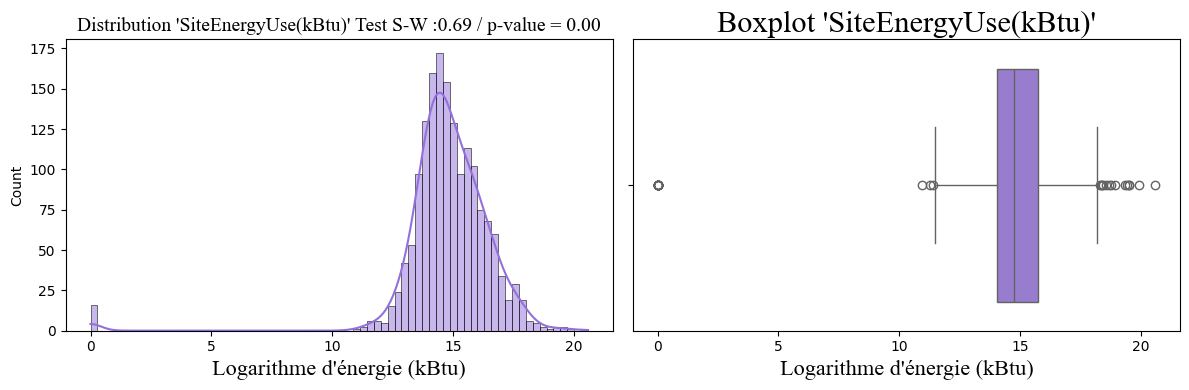

In [354]:
# Transformation logarithmique (log(1+x))
df_data_log[feature_analyzed] = np.log1p(df_data_clean_imputation[feature_analyzed])

# Histogramme
plot_distribution(df_data_log, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Logarithme d'énergie (kBtu)")

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Les données de cet feature cible ne sont malgré tout pas distribuées normalement.**

In [355]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_log, "df_data_log", "des transformations logarithmiques", 2)

Voici l'aspect de 'df_data_log' après nettoyage des transformations logarithmiques


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
0,1,NonResidential,Hotel,Mayflower park hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,60.0,60.0,15.79325,False,Compliant,5.52537,0.54606,0.2773,0.17664
1,2,NonResidential,Hotel,Paramount Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,61.0,61.0,15.94230,False,Compliant,5.69326,0.38661,0.0000,0.61339


1648 ligne(s) x 25 colonne(s)



## <span style='background:green'>10/ Suppression des outliers des features cibles</span>

Avec la méthode interquartile (IQR) :

### <span style='background:yellow; color:black'>a/ TotalGHGEmissions</span>

In [356]:
# Suppression outliers par la méthode interquartile
df_data_clean_ghge = supprimer_outliers_iqr(df_data_log, "TotalGHGEmissions")

### <span style='background:yellow; color:black'>b/ SiteEnergyUse(kBtu)</span>

In [357]:
# Suppression outliers par la méthode interquartile
df_data_clean_outlier = supprimer_outliers_iqr(df_data_clean_ghge, "SiteEnergyUse(kBtu)")

Nous affichons les distributions de la feature "TotalGHGEmissions" après la suppression des outliers par la méthode interquartile (IQR).

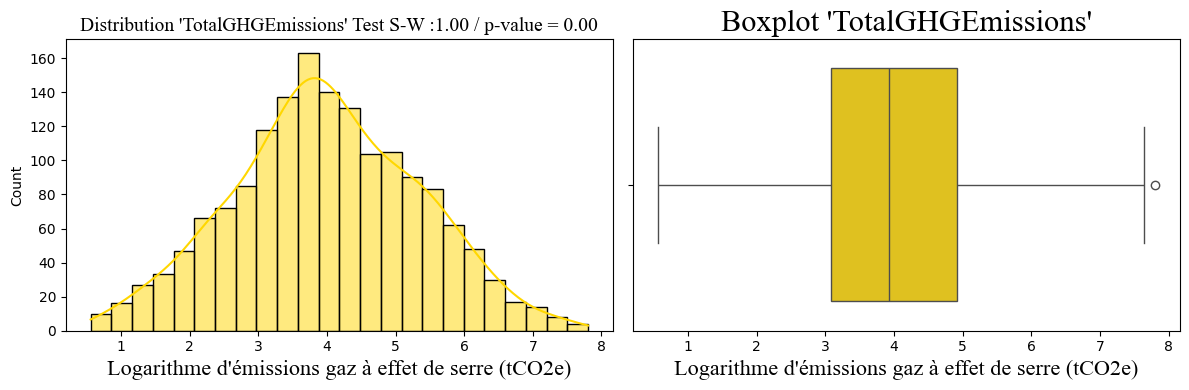

In [358]:
# Histogramme distribution
plot_distribution(df_data_clean_outlier, "TotalGHGEmissions", colors_list[0], shapiro_wilk=True, unit="Logarithme d'émissions gaz à effet de serre (tCO2e)")

Nous affichons les distributions de la feature "SiteEnergyUse(kBtu)" après la suppression des outliers par la méthode interquartile (IQR).

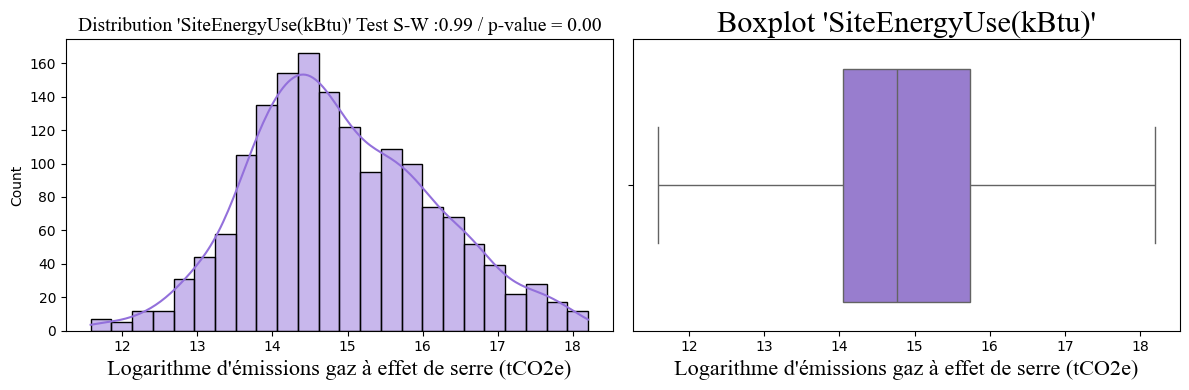

In [359]:
# Histogramme distribution
plot_distribution(df_data_clean_outlier, "SiteEnergyUse(kBtu)", colors_list[1], shapiro_wilk=True, unit="Logarithme d'émissions gaz à effet de serre (tCO2e)")

**Tous les outliers ont été supprimés.**

In [360]:
# Aperçu dataframe nettoyé (données transformées avec le log)
affiche_aperçu_df(df_data_clean_outlier, "df_data_clean_outlier", "des outliers", 3)

Voici l'aspect de 'df_data_clean_outlier' après nettoyage des outliers


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion
0,1,NonResidential,Hotel,Mayflower park hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,60.0,60.0,15.79325,False,Compliant,5.52537,0.54606,0.27730,0.17664
1,2,NonResidential,Hotel,Paramount Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,61.0,61.0,15.94230,False,Compliant,5.69326,0.38661,0.00000,0.61339
2,3,NonResidential,Hotel,5673-The Westin Seattle,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,756493.0,43.0,43.0,18.10030,False,Compliant,7.64505,0.68231,0.29711,0.02058


1610 ligne(s) x 25 colonne(s)



## <span style='background:green'>11/ Création feature ancienneté du bâtiment</span>

Nous calculons l'ancienneté des batiments en soustrayant l'année de mesure (2016) par l'année de construction.

Tout d'abord, nous observons la distribution des années de construction des batiments dans le dataset.

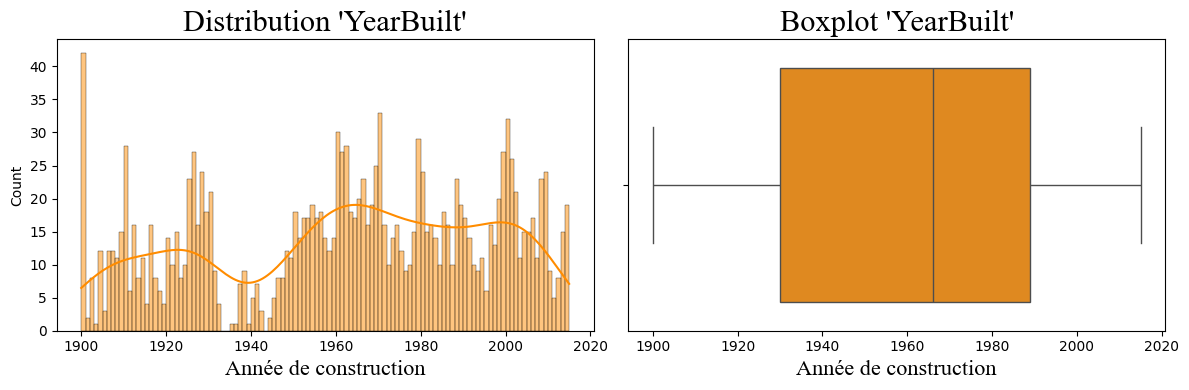

In [361]:
# Histogramme
plot_distribution(df_data_clean_outlier, "YearBuilt", colors_list[2], binwidth=1, unit="Année de construction")

Aucun outlier n'est constaté. Nous utilisons ces données pour créer une nouvelle feature qui indique l'ancienneté des batiments.

In [362]:
# Copie du dataframe
df_data_clean = df_data_clean_outlier.copy()

# Calcul de l'ancienneté du bâtiment
df_data_clean["AncienneteBatiment"] = 2016 - df_data_clean_outlier["YearBuilt"]

Nous observons la distribution de cette nouvelle feature (directement corrélée à celle des années de construction).

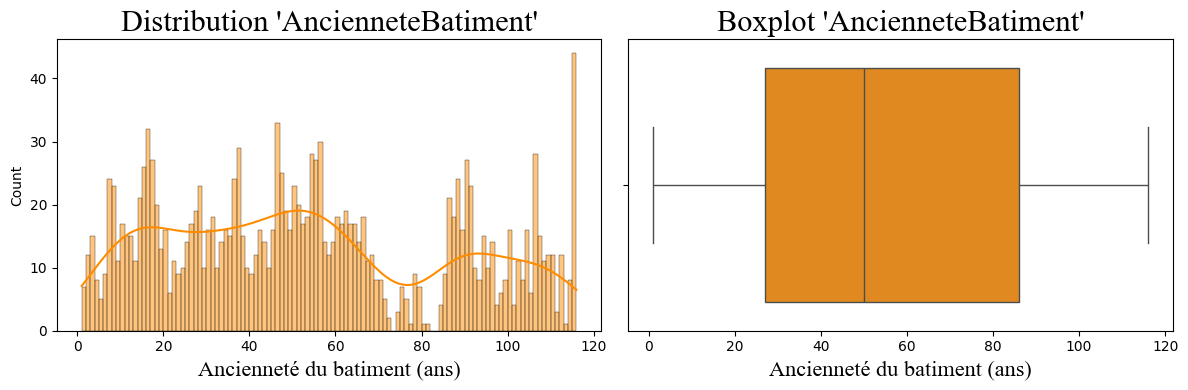

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,27.0,53.9,50.0,86.0,32.7,0.61,0.29,-1.0


In [363]:
# Histogramme
plot_distribution(df_data_clean, "AncienneteBatiment", colors_list[2], binwidth=1, unit="Ancienneté du batiment (ans)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_data_clean, "AncienneteBatiment")
display(df_stat)

Résumé de la distribution de l'ancienneté des batiments : 

- **Aspect** : distribution **trimodale** => 3 zones de fortes concentrations (autour de 16, 50 et 90 ans).
  
- **Tendance centrale** : La **moyenne** et la **médiane** sont proches de 50-55 ans.
  
- **Dispersion** : les données forment un groupe hétérogène (CV > 15%).
  
- **Forme** : les données sont étalées à droite (skewness>0) et les observations sont plus aplaties que la loi normale (kurtosis<0).

Nous supprimons la feature des années de construction des batiments car elle est redondante avec la feature de l'ancienneté des batiments.

In [364]:
# Suppression d'une feature dont nous n'avons plus besoin
df_data_clean = df_data_clean.drop(columns=["YearBuilt"])

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean, "df_data_clean", "des années de construction des bâtiments", 2)

Voici l'aspect de 'df_data_clean' après nettoyage des années de construction des bâtiments


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
0,1,NonResidential,Hotel,Mayflower park hotel,7,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,0,88434,Hotel,88434.0,60.0,60.0,15.79325,False,Compliant,5.52537,0.54606,0.2773,0.17664,89
1,2,NonResidential,Hotel,Paramount Hotel,7,DOWNTOWN,47.61317,-122.33393,1.0,11,103566,15064,88502,Hotel,83880.0,61.0,61.0,15.94230,False,Compliant,5.69326,0.38661,0.0000,0.61339,20


1610 ligne(s) x 25 colonne(s)



## <span style='background:green'>12/ Bilan dataset nettoyé</span>

Le dataset est entièrement nettoyé de ses valeurs manquantes, à l'exception de la feature "ENERGYSTARScore", que nous conservons pour pouvoir évaluer l'impact de l'imputation KNN sur les corrélations.

Valeurs manquantes (Nan) : 542 / 40250 données (1.35 %)
1 / 25 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
ENERGYSTARScore,542,33.660000


1 / 25 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


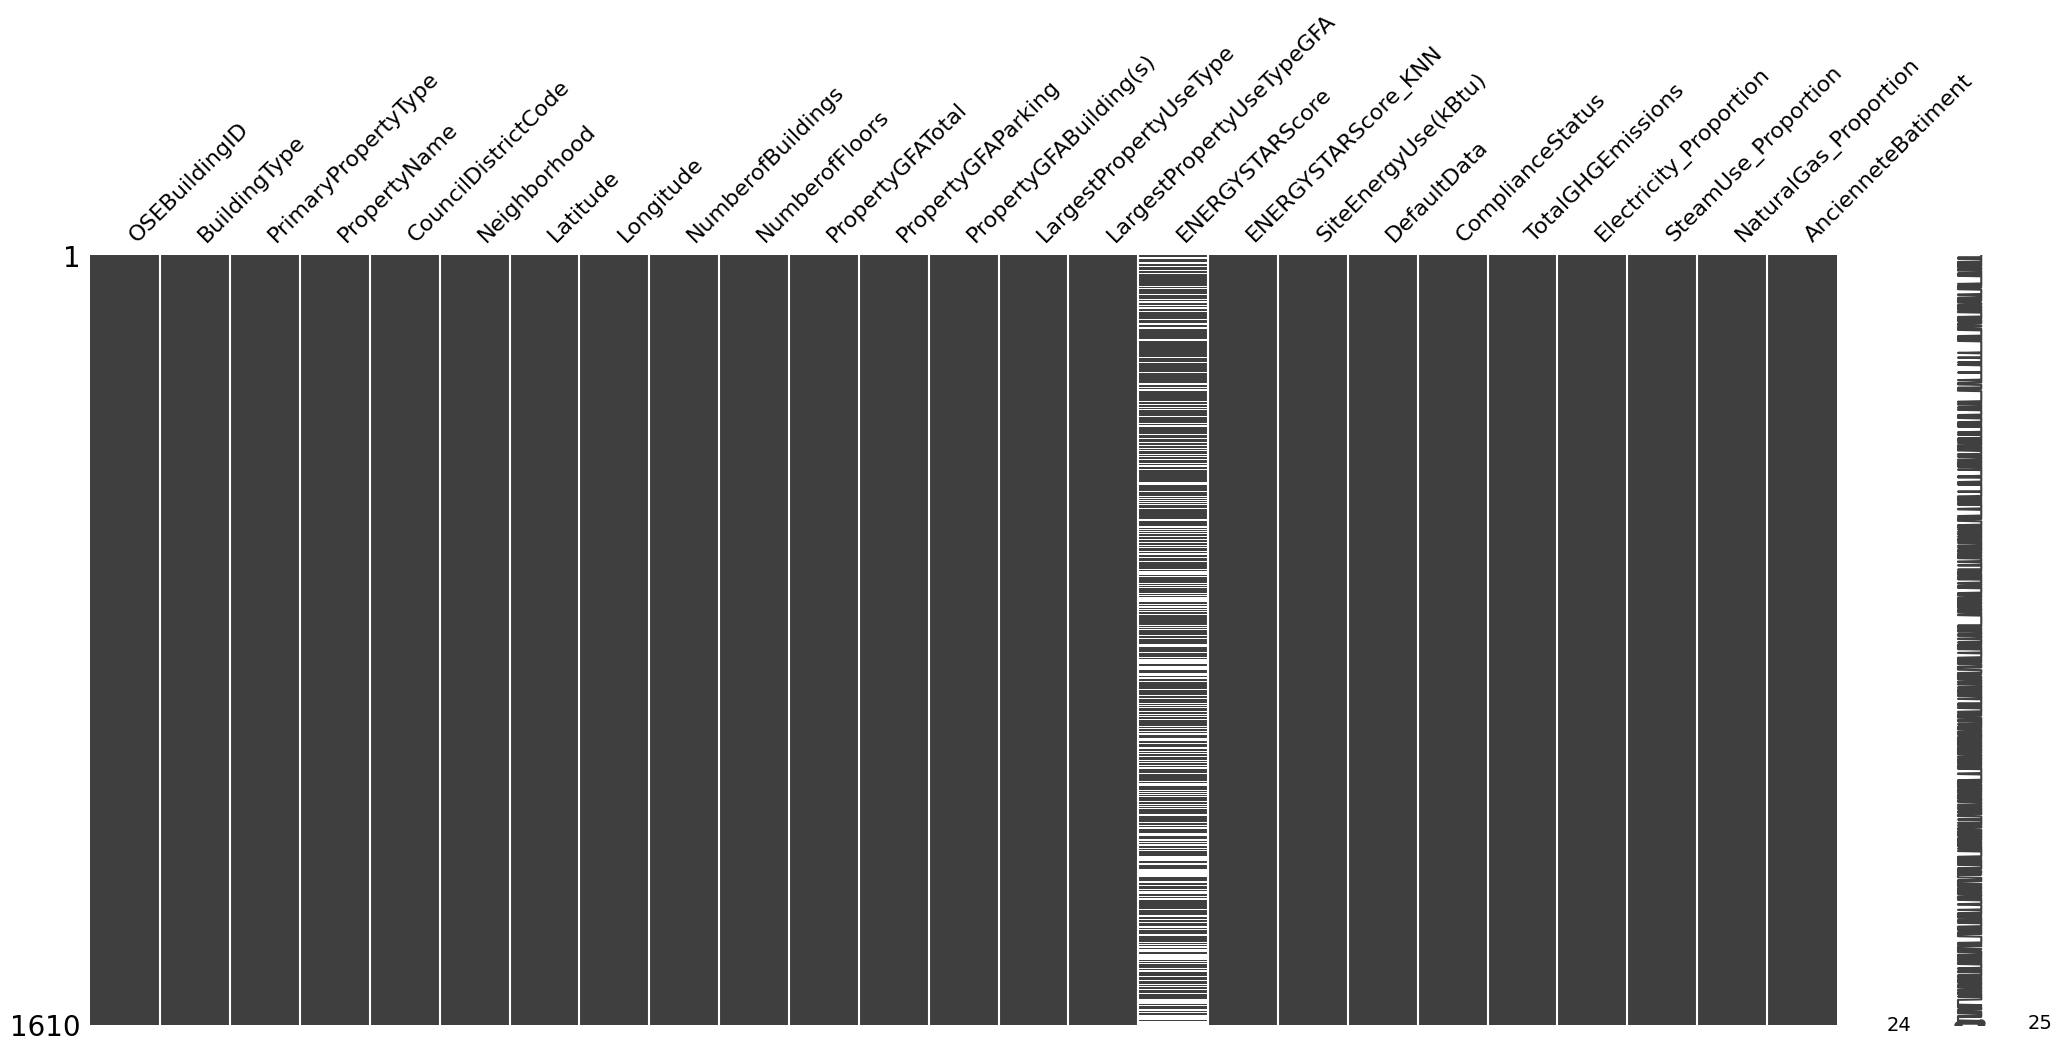

In [365]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean, True, True)

# <span style='background:blue'>Etape 3 : Analyse exploratoire</span>
___

## <span style='background:green'>1/ Analyses univariées</span>


### <span style='background:yellow; color:black'>a/ Types de batiment</span>

Nous observons la répartition des types de batiment dans le dataset. 

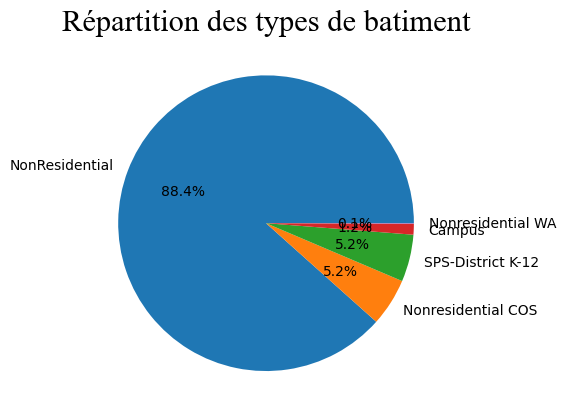

In [366]:
# Compte les ID de batiment par type de batiment (ordre décroissant)
repartition_type_batiment = df_data_clean.groupby(by='BuildingType')['OSEBuildingID'].nunique().sort_values(ascending=False)

# Convert index to list of strings
labels = repartition_type_batiment.index.tolist()

# Diagramme camembert 
plt.pie(repartition_type_batiment, labels=labels, 
    autopct='%1.1f%%') 

# Ajout du titre et légende
plt.title("Répartition des types de batiment", fontdict=font_title)
plt.show()

Le type de batiment le plus représenté est le 'NonResidential' avec 88,4% des batiments.

### <span style='background:yellow; color:black'>b/ Types d'usage</span>

Nous allons explorer la répartition des 10 premiers types d'usage dans 'LargestPropertyUseType'. 

C:\Users\pierr\AppData\Local\Temp\ipykernel_348\1400072297.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_counts.index, rotation=45, ha='right')


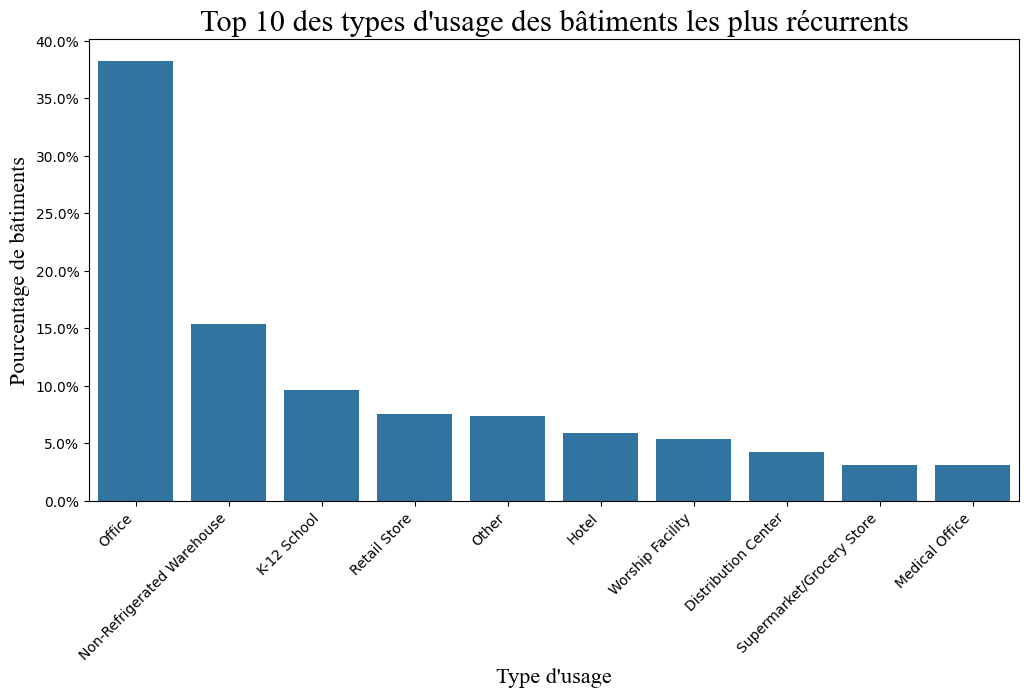

In [367]:
# Compter les occurrences par type d'usage dans feature 'LargestPropertyUseType'
counts = df_data_clean['LargestPropertyUseType'].value_counts()

# Nombre des premières valeurs à afficher
top_nombre = 10
top_counts = counts.head(10)

# Calculez le pourcentage par rapport au total
total = top_counts.sum()
pourcentages = (top_counts / total) * 100

# Créer un barplot avec Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_counts.index, y=pourcentages)

# Ajout du titre du graphique, des axes X et Y
plt.title("Top {} des types d'usage des bâtiments les plus récurrents".format(top_nombre), fontdict=font_title)
plt.xlabel("Type d'usage", fontdict=font_axe)
plt.ylabel("Pourcentage de bâtiments", fontdict=font_axe)
ax.set_xticklabels(top_counts.index, rotation=45, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Les bureaux représentent le type d'usage le plus récurrent dans le dataset. Ils représentent plus d'un tiers des types d'usage.

Plus de la moitié des types d'usage sont soit des bureaux, soit des entrepôts non-réfrigérés.

### <span style='background:yellow; color:black'>c/ Energie par type d'usage</span>

Nous explorons la quantité d'énergie consommée par les 10 premiers types d'usage.

C:\Users\pierr\AppData\Local\Temp\ipykernel_348\2672490567.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


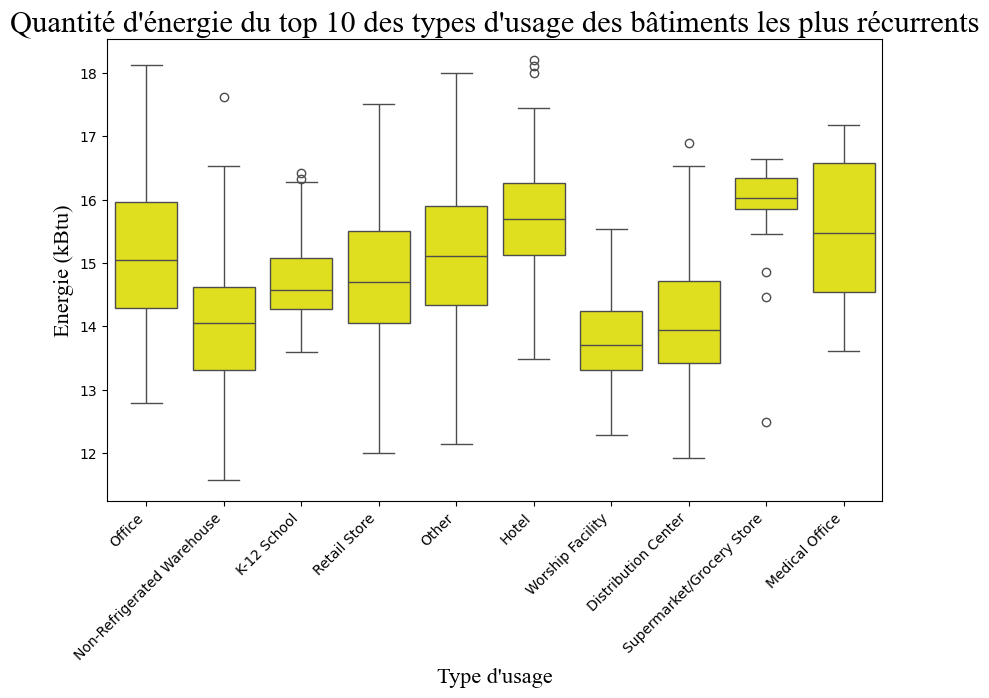

In [368]:
# Sous-ensemble avec les valeurs de type d'usage dans le top count
subset = df_data_clean[df_data_clean['LargestPropertyUseType'].isin(top_counts.index)]

# Remodeler le dataframe
melted = pd.melt(subset, id_vars=['LargestPropertyUseType'], value_vars=['SiteEnergyUse(kBtu)'])

# Tracez le boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='LargestPropertyUseType', y='value', data=melted, order=top_counts.index, color="yellow")

# Ajout du titre du graphique, des axes X et Y
plt.title("Quantité d'énergie du top {} des types d'usage des bâtiments les plus récurrents".format(top_nombre), fontdict=font_title)
plt.xlabel("Type d'usage", fontdict=font_axe)
plt.ylabel("Energie (kBtu)", fontdict=font_axe)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Les supermarchés sont les plus gros consommateurs d'énergie. Ils sont suivis par les cabinets médicaux et les hôtels. Ils représentent chacun env. 5% des types d'usage des bâtiments du dataset.

Le type d'usage le plus présent (bureau) est le 4ème plus gros consommateur d'énergie.

Nous explorons la répartition des sources d'énergie des 10 premiers types d'usage.

C:\Users\pierr\AppData\Local\Temp\ipykernel_348\371069647.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\pierr\AppData\Local\Temp\ipykernel_348\371069647.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


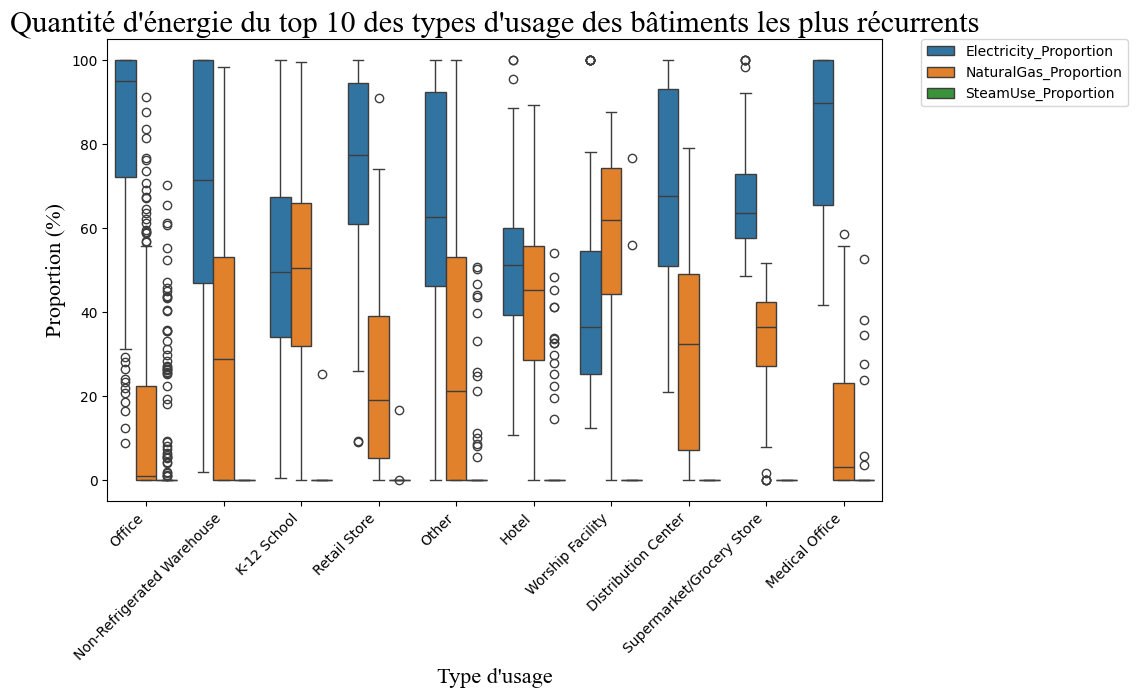

In [369]:
# Remodeler le dataframe
melted = pd.melt(subset, id_vars=['LargestPropertyUseType'], value_vars=['Electricity_Proportion', 'NaturalGas_Proportion', 'SteamUse_Proportion'])

# Multiplier les valeurs de l'axe y par 100
melted['value'] = melted['value'] * 100

# Tracez le boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='LargestPropertyUseType', y='value', hue='variable', data=melted, order=top_counts.index)

# Définissez les étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Déplacez la légende en dehors du tracé
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Ajout du titre du graphique, des axes X et Y
plt.title("Quantité d'énergie du top {} des types d'usage des bâtiments les plus récurrents".format(top_nombre), fontdict=font_title)
plt.xlabel("Type d'usage", fontdict=font_axe)
plt.ylabel("Proportion (%)", fontdict=font_axe)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

La vapeur d'eau est une source d'énergie toujours très minoritaire.

Le gaz naturel concurrence l'électricité comme source d'énergie pour les écoles, les hôtels et les lieux de culte. 

Pour les 7 autres types d'usage, l'électricité est la source d'énergie la plus utilisée.

## <span style='background:green'>2/ Analyses bivariées</span>

### <span style='background:yellow; color:black'>a/ Matrice de corrélation"</span>

Nous affichons une matrice de corrélation de toutes les variables quantitatives de notre dataset pour pouvoir détecter les corrélations linéaires les plus visibles grâce aux coefficients de corrélation de Pearson. 

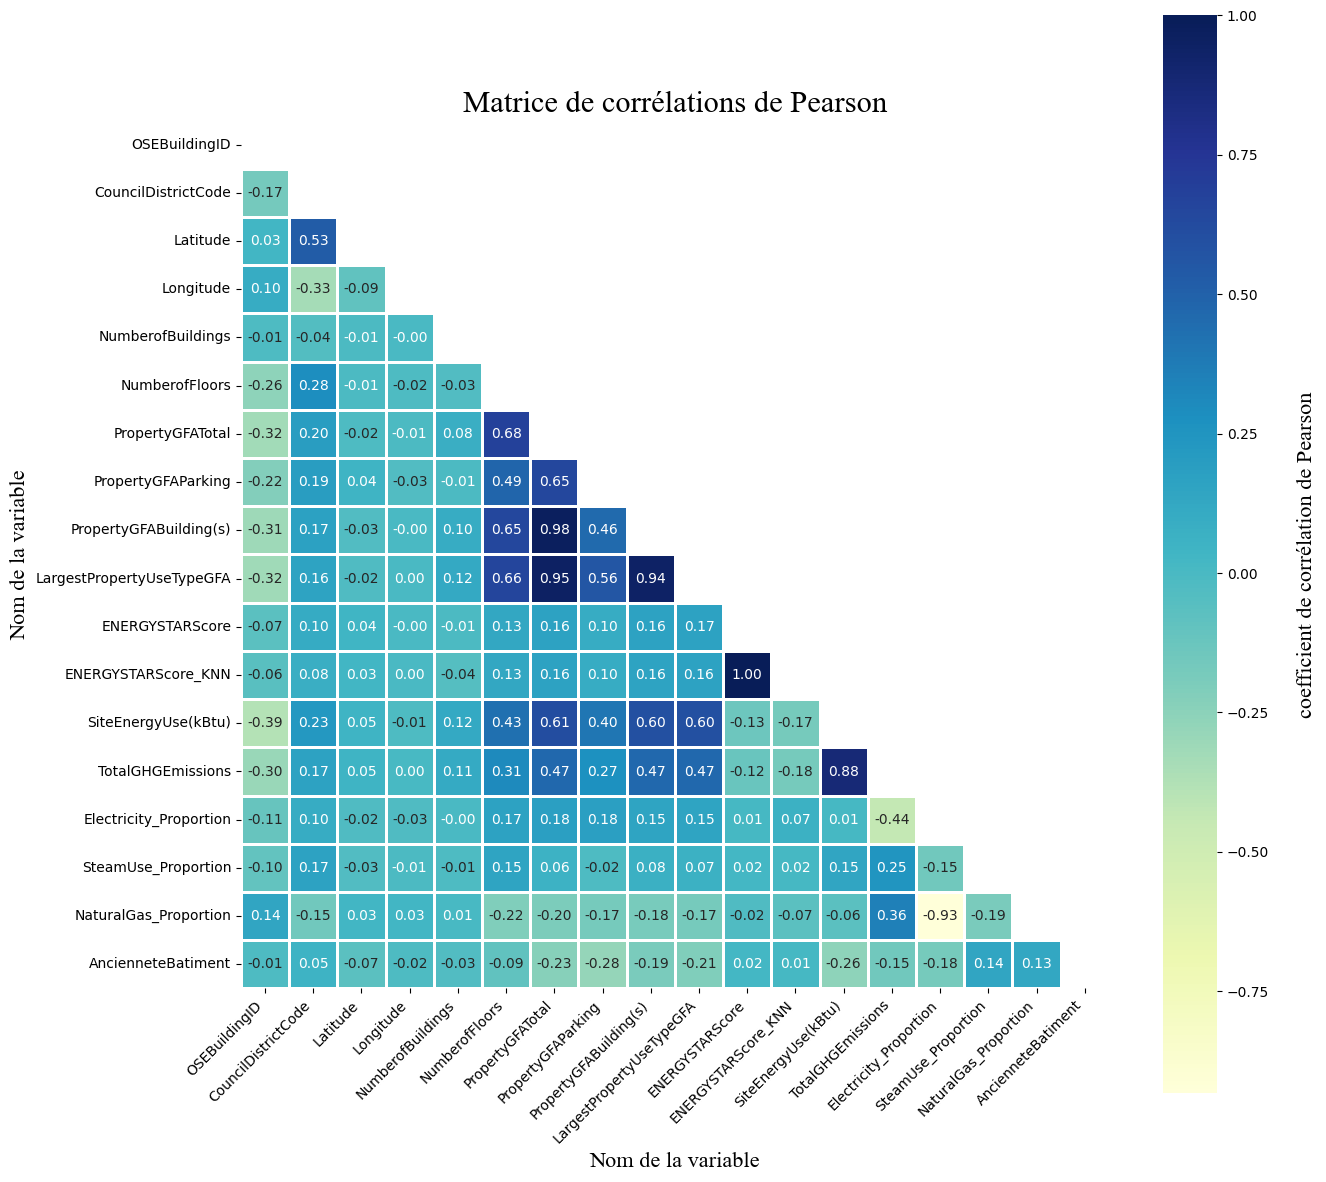

In [370]:
# Comptage du nombre de feature quantitatives
feat_quanti_list = df_data_clean.select_dtypes(include=['int', 'float']).columns

# Matrice des corrélations
corr_mat = df_data_clean[feat_quanti_list].corr()

# Créer un masque pour masquer les valeurs au-dessus de la diagonale
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# heatmap
fig, ax = plt.subplots(figsize=(14,14))
heatmap = sns.heatmap(corr_mat, square=True, linewidths=1, annot=True, fmt=".2f", cmap='YlGnBu', mask=mask, ax=ax)

# Ajout du titre du graphique, des axes et de la colorbar
plt.title("Matrice de corrélations de Pearson", fontdict=font_title)
plt.xlabel("Nom de la variable", fontdict=font_axe)
plt.ylabel("Nom de la variable", fontdict=font_axe)
plt.xticks(rotation=45, ha='right')
cbar = heatmap.collections[0].colorbar
cbar.set_label('coefficient de corrélation de Pearson', labelpad=20, fontdict=font_axe)  
plt.show()

Les features cibles ne présentent pas de forte corrélation avec la feature d'ENERGYSTARScore : 
- SiteEnergyUse(kBtu) / ENERGYSTARScore => R = -0,13    (R = -0,17 avec imputation KNN)
- TotalGHGEmissions / ENERGYSTARScore => R = -0,12      (R = -0,18 avec imputation KNN)

**Les features cibles ne sont pas corrélées à la valeur de l'ENERGYSTARScore. Cette dernière ne devrait pas être importante pour le modèle.**

Nous supprimons les features qui présentent des corrélations linéaires fortes (R > 0,50) entre elles pour améliorer la performance du modèle de machine learning, en particulier :
- Augmenter la vitesse d'apprentissage
- Augmenter la l'interpretabilité du modèle
- Augmenter la stabilité du modèle
- Réduire le fléau de la dimension  

In [371]:
# Seuil de corrélation
seuil_corr = 0.50

# Matrice des corrélations mise à jour
corr_mat = df_data_clean[feat_quanti_list].corr()

#### <span style='background:white; color:black'>Corrélation avec "SiteEnergyUse(kBtu)"</span>

Si nous nous concentrons sur la feature cible "SiteEnergyUse(kBtu)" :

In [372]:
# Feature cible
target = "SiteEnergyUse(kBtu)"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=target, seuil=seuil_corr)

,Feature cible,Feature associée,Corrélation
0,SiteEnergyUse(kBtu),PropertyGFATotal,0.61
1,SiteEnergyUse(kBtu),PropertyGFABuilding(s),0.60
2,SiteEnergyUse(kBtu),LargestPropertyUseTypeGFA,0.60
3,SiteEnergyUse(kBtu),TotalGHGEmissions,0.88


Cette feature cible présente une corrélation avec l'autre feature cible "TotalGHGEmissions" (R = 0,88). Nous affichons l'analyse bivariée de ces 2 features cibles pour visualiser la corrélation, ainsi que la régression linéaire pour visualiser la tendance.

Pour savoir si ces 2 features sont réellement corrélées ou pas, nous devons poser les hypothèses du test de corrélation de Spearman :

**Hypothèse nulle (H0) : Pas de corrélation entre les 2 variables.**

Hypothèse alternative (HA) : Corrélation entre les 2 variables.

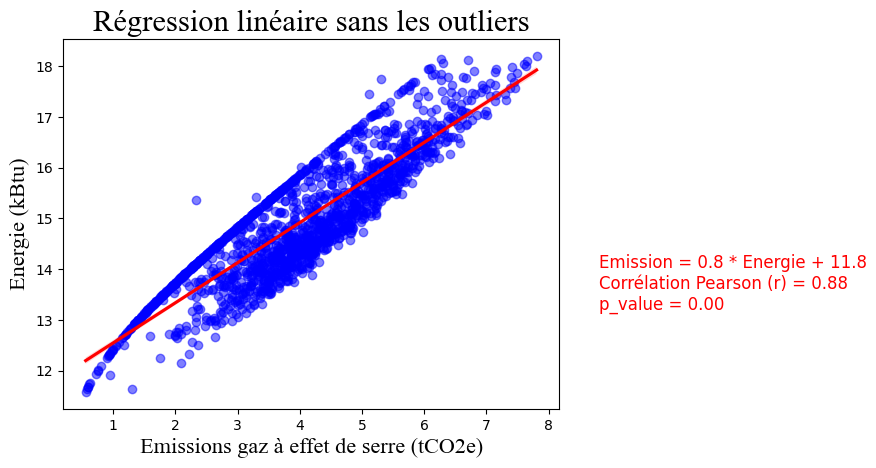

In [373]:
# Regression linéaire
regression_lineaire_emission_energie(df_data_clean, "TotalGHGEmissions", "SiteEnergyUse(kBtu)", "Emission", "Energie", outliers_statut="sans")

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Il existe une corrélation positive entre les émissions de gaz à effet de serre et la quantité annuelle d'énergie consommée  (R=0.88)**

Nous constatons que **"SiteEnergyUse(kBtu)"** est également corrélée à :
  - "PropertyGFATotal" (R = 0,61)
  - "PropertyGFABuilding(s)" (R = 0,60)
  - "LargestPropertyUseTypeGFA" (R = 0,60)  **=> nous conservons cette corrélation**

**Ainsi nous regroupons les features "PropertyGFATotal" et "PropertyGFABuilding(s)" dans une liste des features à supprimer.**

#### <span style='background:white; color:black'>Corrélation avec "TotalGHGEmissions"</span>

Si nous nous concentrons sur la feature cible "TotalGHGEmissions" :

In [374]:
# Feature cible
target = "TotalGHGEmissions"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=target, seuil=seuil_corr)

,Feature cible,Feature associée,Corrélation
0,TotalGHGEmissions,SiteEnergyUse(kBtu),0.88


Nous constatons que **"TotalGHGEmissions"** est n'est corrélée qu'à l'autre feature cible "SiteEnergyUse(kBtu)" (R = 0,88).

#### <span style='background:white; color:black'>Corrélation avec les meilleurs corrélations des features cibles</span>

Maintenant que nous connaissons la feature corrélée que nous devons conserver pour sa forte corrélation avec les features cibles, à savoir:
- "LargestPropertyUseTypeGFA"
  
Nous allons supprimer les features qui présentent des corrélations linéaires fortes avec cette dernière pour améliorer la stabilité des modèles de machine learning qui seront réalisés par la suite. 

In [375]:
# Feature cible
target = "LargestPropertyUseTypeGFA"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=target, seuil=seuil_corr)

,Feature cible,Feature associée,Corrélation
0,LargestPropertyUseTypeGFA,NumberofFloors,0.66
1,LargestPropertyUseTypeGFA,PropertyGFATotal,0.95
2,LargestPropertyUseTypeGFA,PropertyGFAParking,0.56
3,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),0.94
4,LargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),0.60


Ainsi, nous constatons que :

- **"LargestPropertyUseTypeGFA"** est corrélé à :
  - "NumberofFloors" (R = 0,66)
  - "PropertyGFATotal" (R = 0,95)
  - "PropertyGFAParking" (R = 0,56)
  - "PropertyGFABuilding" (R = 0,94)

**Ainsi nous ajoutons les features "NumberofFloors", "PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)" à la liste des features à supprimer.**

#### <span style='background:white; color:black'>Autres corrélations restantes</span>

Focalisons nous sur la feature "Latitude": 

In [376]:
# Feature cible
target = "Latitude"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=target, seuil=seuil_corr)

,Feature cible,Feature associée,Corrélation
0,Latitude,CouncilDistrictCode,0.53


Ainsi, nous constatons que :

- **"Latitude"** est corrélé à :
  - "CouncilDistrictCode" (R = 0,53)

**Ainsi nous ajoutons les features "CouncilDistrictCode" à la liste des features à supprimer.**

Nous supprimons toutes les features qui présentent des corrélations linéaires fortes 

In [377]:
# Liste des features corrélées
corr_feat_list = ["PropertyGFATotal",
                "PropertyGFABuilding(s)",
                "NumberofFloors",
                "PropertyGFAParking",
                "CouncilDistrictCode"]

# Suppression des features corrélées
df_data_clean_corr = df_data_clean.drop(columns=corr_feat_list)

Nous vérifions que les dernières corrélations restantes sont celles en lien avec les features cibles.

In [378]:
# Détection des features quantitatives
feat_quanti_list = df_data_clean_corr.select_dtypes(include=['int', 'float']).columns

# Affichage
display("Il reste {} features quantitatives.".format(len(feat_quanti_list)))
display(feat_quanti_list)

# Matrice des corrélations mise à jour
corr_mat = df_data_clean_corr[feat_quanti_list].corr()

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, seuil=seuil_corr)

'Il reste 13 features quantitatives.'

Index(['OSEBuildingID', 'Latitude', 'Longitude', 'NumberofBuildings',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'ENERGYSTARScore_KNN',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Electricity_Proportion',
       'SteamUse_Proportion', 'NaturalGas_Proportion', 'AncienneteBatiment'],
      dtype='object')

,Feature cible,Feature associée,Corrélation
0,LargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),0.60
1,ENERGYSTARScore,ENERGYSTARScore_KNN,1.00
2,SiteEnergyUse(kBtu),TotalGHGEmissions,0.88


Il s'agit bien des corrélation avec les features cibles. Nous trouvons également les 2 features de l'ENERGYSTARScore qui sont directement corrélées entre elles. 
Nous pouvons donc conserver ces features pour la suite des traitements.

In [379]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_corr, "df_data_clean_corr", "des features colinéaires", 3)

Voici l'aspect de 'df_data_clean_corr' après nettoyage des features colinéaires


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,Latitude,Longitude,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
0,1,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,47.61220,-122.33799,1.0,Hotel,88434.0,60.0,60.0,15.79325,False,Compliant,5.52537,0.54606,0.27730,0.17664,89
1,2,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,47.61317,-122.33393,1.0,Hotel,83880.0,61.0,61.0,15.94230,False,Compliant,5.69326,0.38661,0.00000,0.61339,20
2,3,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,47.61393,-122.33810,1.0,Hotel,756493.0,43.0,43.0,18.10030,False,Compliant,7.64505,0.68231,0.29711,0.02058,47


1610 ligne(s) x 20 colonne(s)



Valeurs manquantes (Nan) : 542 / 32200 données (1.68 %)
1 / 20 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
ENERGYSTARScore,542,33.660000


1 / 20 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


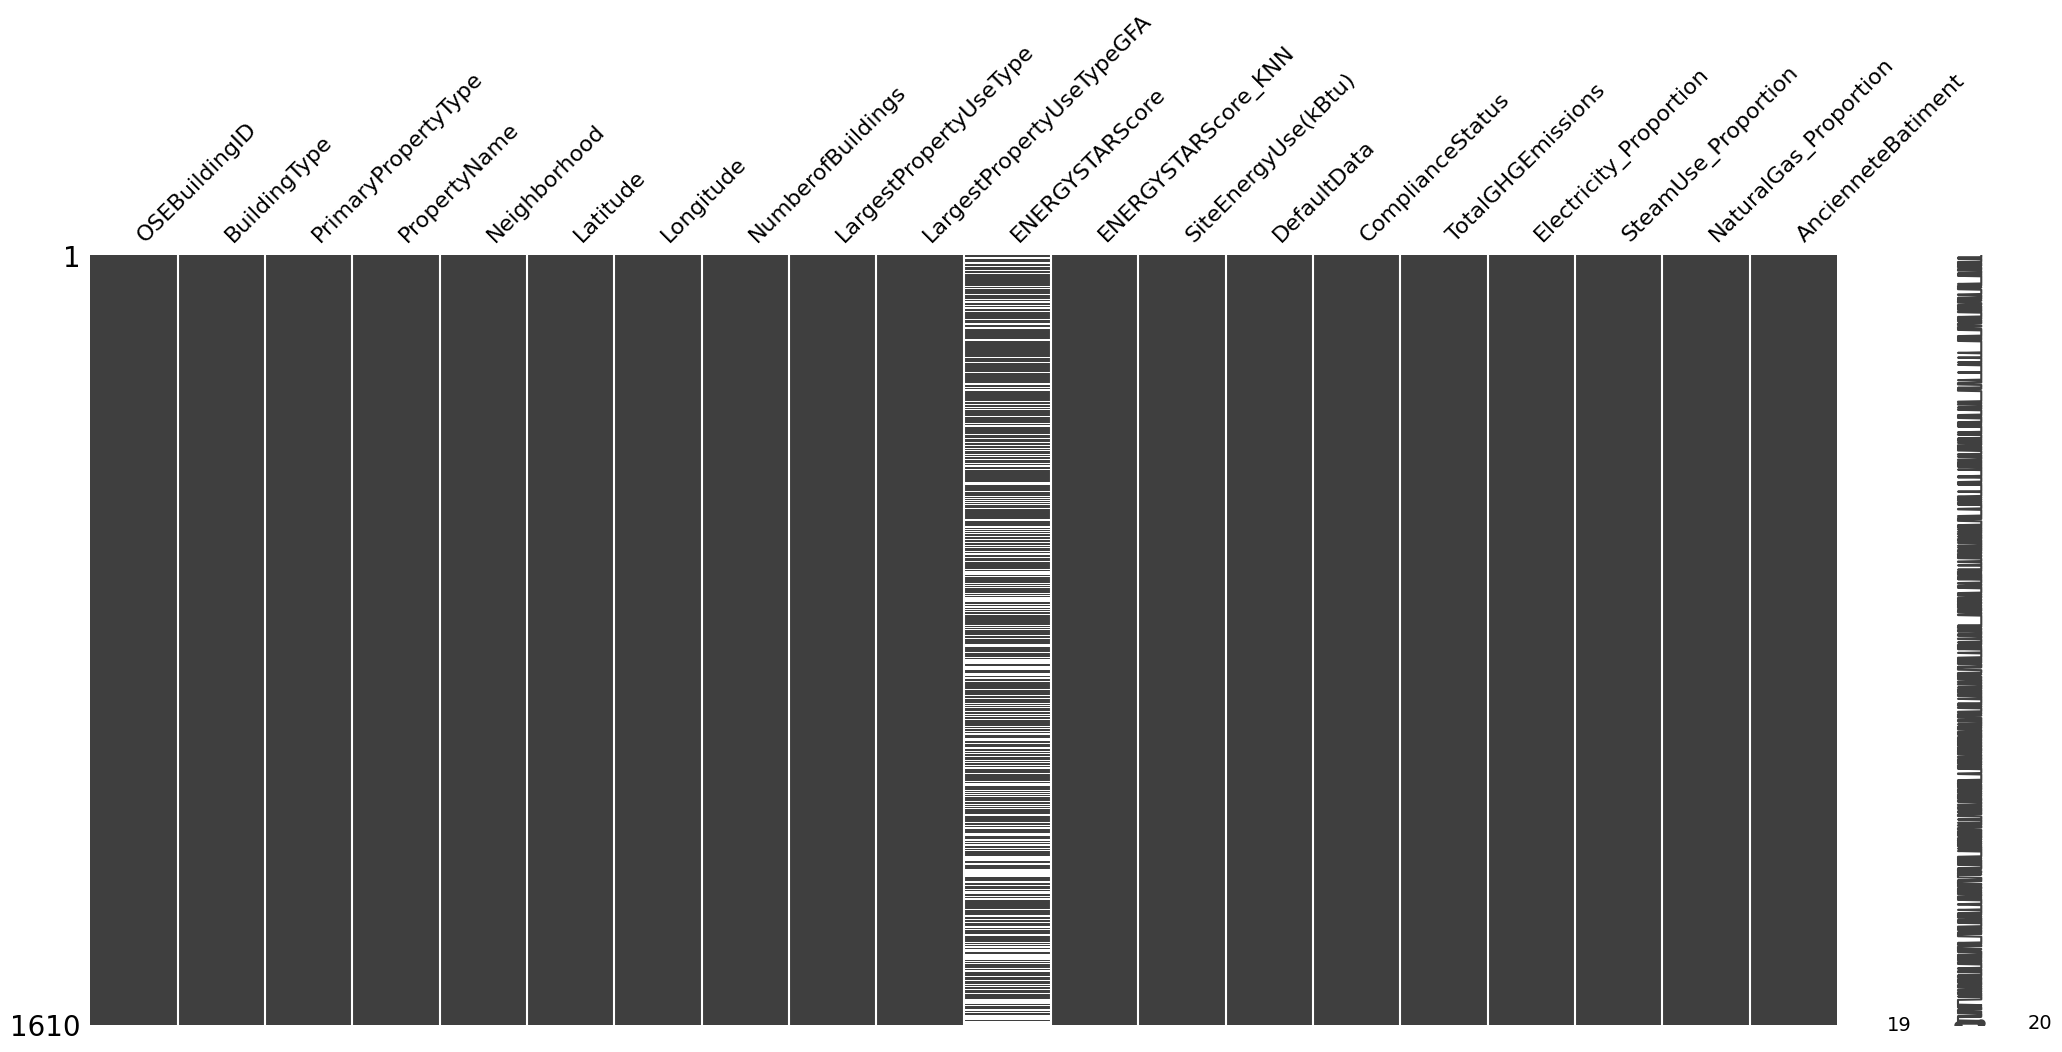

In [380]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_corr, True, True)

La feature ENERGYSTARScore présente des valeurs manquantes mais cela est normal puisque nous avons créé une nouvelle feature avec les valeurs imputées. Nous gardons les 2 features. 

### <span style='background:yellow; color:black'>b/ Variance Inflation Factor (VIF)</span>

Nous étudions la multicollinéarité des features restantes avec le VIF (Variance Inflation Factor) pour assurer une bonne stabilité des modèles de machine learning qui seront réalisés par la suite.

Tout d'abord, nous supprimons les features cibles du dataset pour analyser le VIF des features explicatives de nos prochains modèles de machine learning. 

Egalement, nous supprimons la feature présentant des valeurs manquantes car le calcul du VIF ne fonctionnera pas avec des valeurs manquantes.

In [381]:
# suppression de la feature 'ENERGYSTARScore' (avec Nan) et des features cibles
df_data_clean_vif_temp = df_data_clean_corr.drop(columns=["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "ENERGYSTARScore"])

# Calculer le VIF pour chaque variable explicative
vif_data = calcule_vif(df_data_clean_vif_temp)
print(vif_data)

                     feature           VIF
2                  Longitude  982253.28997
1                   Latitude  981765.89052
6     Electricity_Proportion     478.49544
8      NaturalGas_Proportion     127.99405
7        SteamUse_Proportion       8.35286
5        ENERGYSTARScore_KNN       6.81848
9         AncienneteBatiment       4.13828
0              OSEBuildingID       2.75987
3          NumberofBuildings       2.04125
4  LargestPropertyUseTypeGFA       1.75981


Nous remarquons que les 2 features "Longitude" et "Latitude" présentent un VIF > 900_000. Ces 2 features présentent une forte multicollinéarité avec plusieurs features du dataset. 

Nous allons donc les supprimer et recalculer le VIF du dataset pour vérifier que les autres features ne présentent pas de forte multicollinéarité.

In [382]:
# suppression de la feature 'ENERGYSTARScore' (avec Nan) et des features cibles
df_data_clean_vif = df_data_clean_vif_temp.drop(columns=["Longitude", "Latitude"])

# Calculer le VIF pour chaque variable explicative
vif_data = calcule_vif(df_data_clean_vif)
print(vif_data)

                     feature      VIF
4     Electricity_Proportion  7.85350
3        ENERGYSTARScore_KNN  6.79006
7         AncienneteBatiment  4.07662
6      NaturalGas_Proportion  3.28454
0              OSEBuildingID  2.72844
1          NumberofBuildings  2.03883
2  LargestPropertyUseTypeGFA  1.75427
5        SteamUse_Proportion  1.20706


Nous remarquons que toutes les features présentent un VIF < 10. Nous pouvons donc conserver toutes ces features pour implémenter nos modèles de machine learning.

In [383]:
# Aperçu dataframe nettoyé (données initiales)
affiche_aperçu_df(df_data_clean_vif, "df_data_clean_vif", "des features présentant des multicollinéarités", 3)

Voici l'aspect de 'df_data_clean_vif' après nettoyage des features présentant des multicollinéarités


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore_KNN,DefaultData,ComplianceStatus,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
0,1,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1.0,Hotel,88434.0,60.0,False,Compliant,0.54606,0.27730,0.17664,89
1,2,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1.0,Hotel,83880.0,61.0,False,Compliant,0.38661,0.00000,0.61339,20
2,3,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,1.0,Hotel,756493.0,43.0,False,Compliant,0.68231,0.29711,0.02058,47


1610 ligne(s) x 15 colonne(s)



## <span style='background:green'>3/ Analyses multivariées</span>

### <span style='background:yellow; color:black'>Analyse en Composante Principale (ACP)</span>

Nous vérifions d'abord que le dataframe est entièrement rempli.

Valeurs manquantes (Nan) : 0 / 24150 données (0.0 %)
0 / 15 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


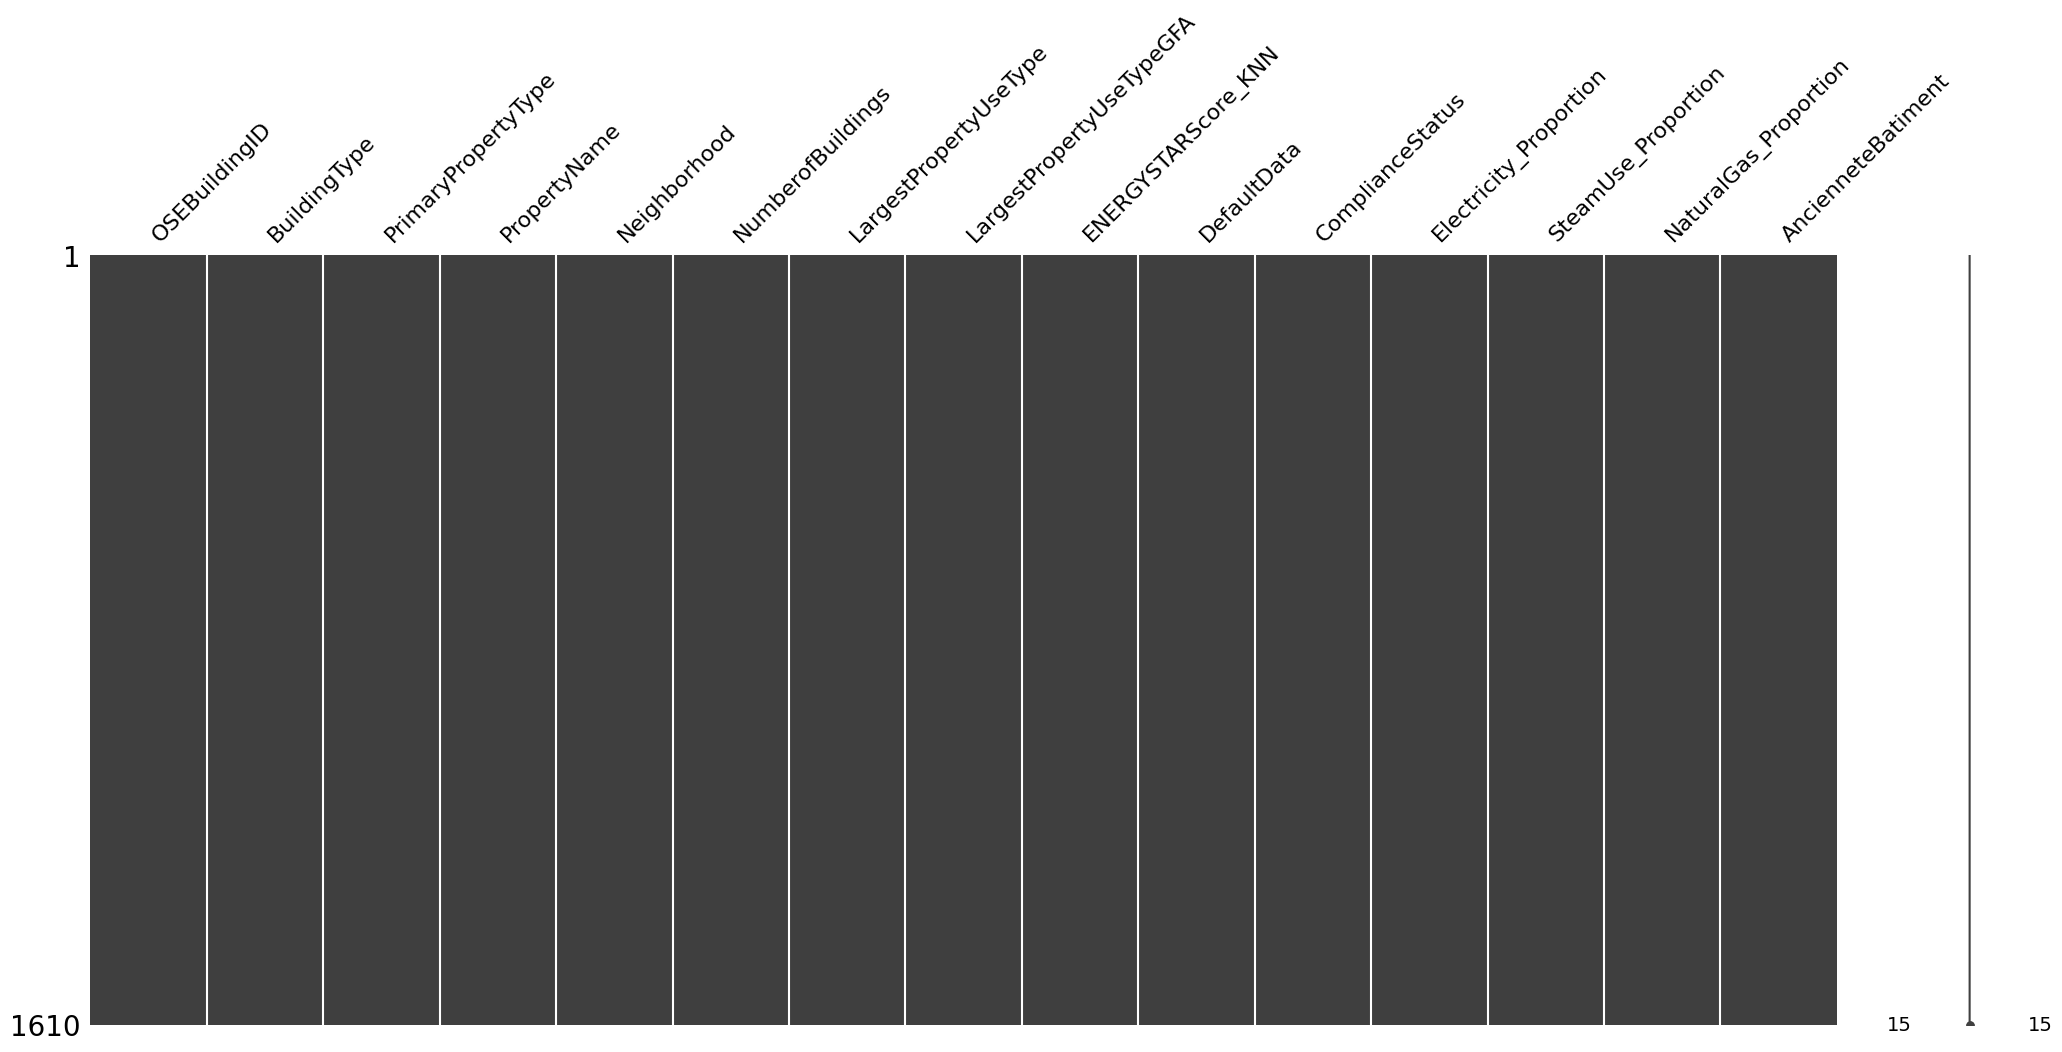

In [384]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_vif, False, True)

Nous paramétrons les données d'entrée de l'ACP en ne conservant que les features quantitatives.

In [385]:
# Dataframe des feature quantitatives (sauf "ENERGYSTARScore" avec des NaN)
feat_quanti_list = df_data_clean_vif.select_dtypes(include=['int', 'float']).columns

# Dataframe des valeurs quantitatives (et ses noms de features)
df_data_float = df_data_clean_vif[feat_quanti_list]

# Dataframe des valeurs quantitatives (et ses noms de features)
X = df_data_float
features = df_data_float.columns

# Dimension X
display(X.shape)

(1610, 8)

Nous effectuons un centrage et une réduction de nos donnés grâce au Scaler de la librairie "sklearn". 

In [386]:
# On instancie notre scaler
scaler = StandardScaler()

# Application du scaler sur les données (et transformation en df)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Affichage de la moyenne et ecart-type
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,OSEBuildingID,NumberofBuildings,LargestPropertyUseTypeGFA,ENERGYSTARScore_KNN,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
mean,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Les données scalées ont bien été centrées (moyenne = 0) et réduites (ecart-type = 1)

##### Eboulis des valeurs propres

Nous allons étudier le nombre de composante utiles à étudier grâce au critère de Kaiser (100 / nombre de composante) et afficher le pourcentage d'inertie totale associé à chaque composante grâce au diagramme de l'éboulis des valeurs propres.

L'ACP a trouvé 8 composantes qui déterminent 100.0 % du dataframe.

Soit un seuil de Kaiser = 12.5, les composantes principales à conserver sont les composantes 1 à 4.


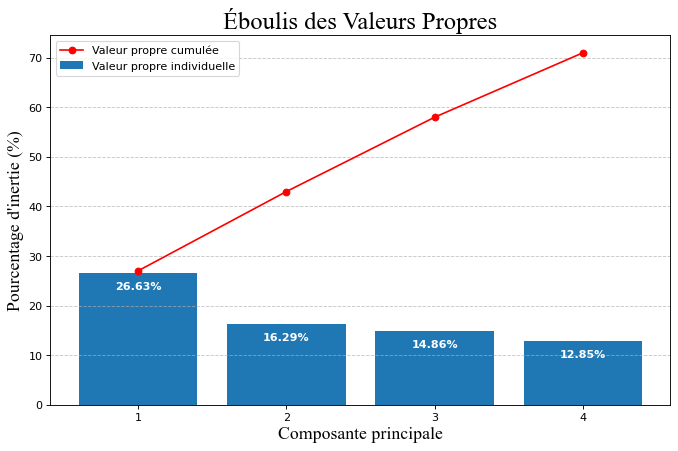

In [387]:
# Instanciation et entrainement de l'ACP
acp = PCA()
acp.fit(X_scaled)

# Fonction qui crée l'éboulis des valeur propres à partir du critère de Kaiser
composante_sup_kaiser_list, x_list = eboulis_valeurs_propres(acp, features)

Nous remarquons que seuls les 4 premières composantes principales respectent le critère de Kaiser. Elles représentent plus de 70% de l'inertie totale. 

#### <span style='background:white; color:black'>Heatmap des composantes principales</span>

Nous allons calculer les coefficients assiociés à chaque features pour chacune des composantes principales. 

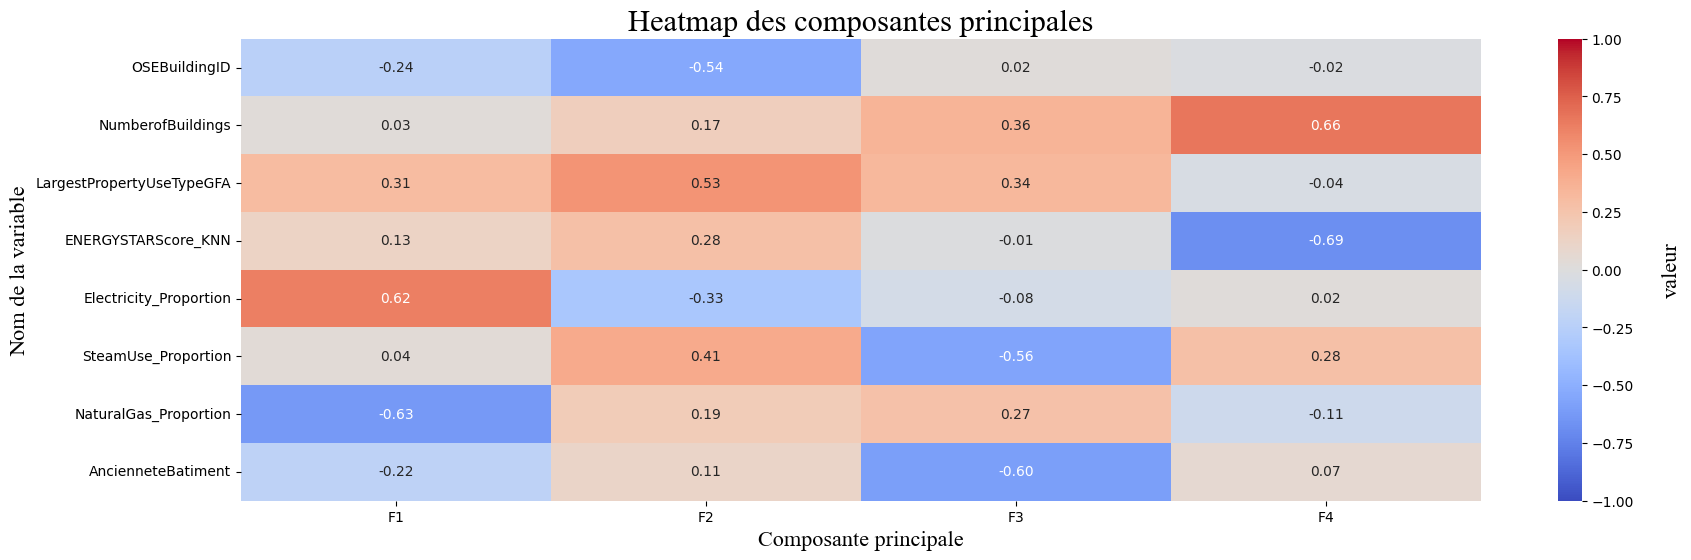

In [388]:
# Nombre de composante principales retenus (suite à Kaiser)
nb_composante_retenues = composante_sup_kaiser_list[-1]

# Instanciation et entrainement ACP sur les composantes principales retenues
acp_retenue = PCA(n_components=nb_composante_retenues)
acp_retenue.fit(X_scaled)

# Séparation des composantes principales retenues (attribution nom de ligne/col)
pcs = pd.DataFrame(acp_retenue.components_)
pcs.columns = features
pcs.index = pd.Index([f"F{i}" for i in x_list])

# Heatmap des composantes principales retenues
fig, ax = plt.subplots(figsize=(20, 6))
heatmap = sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

# Ajout titre et label de la color bar
plt.title('Heatmap des composantes principales', fontdict=font_title)
plt.xlabel("Composante principale", fontdict=font_axe)
plt.ylabel("Nom de la variable", fontdict=font_axe)
cbar = ax.collections[0].colorbar
cbar.set_label('valeur', labelpad=20, fontdict=font_axe)
plt.show()

#### <span style='background:white; color:black'>Plan factoriel</span>

Une autre méthode d'affichage des composantes principales consiste à afficher leur plan factoriel et leur cercle de corrélation.

On crée d'abord le dataframe avec la projection des données sur les 4 plans factoriels retenus.

In [389]:
X_proj = acp_retenue.transform(X_scaled)

##### SiteEnergyUse (kBtu)
Plan factoriel et cercle de corrélation F1 et F2

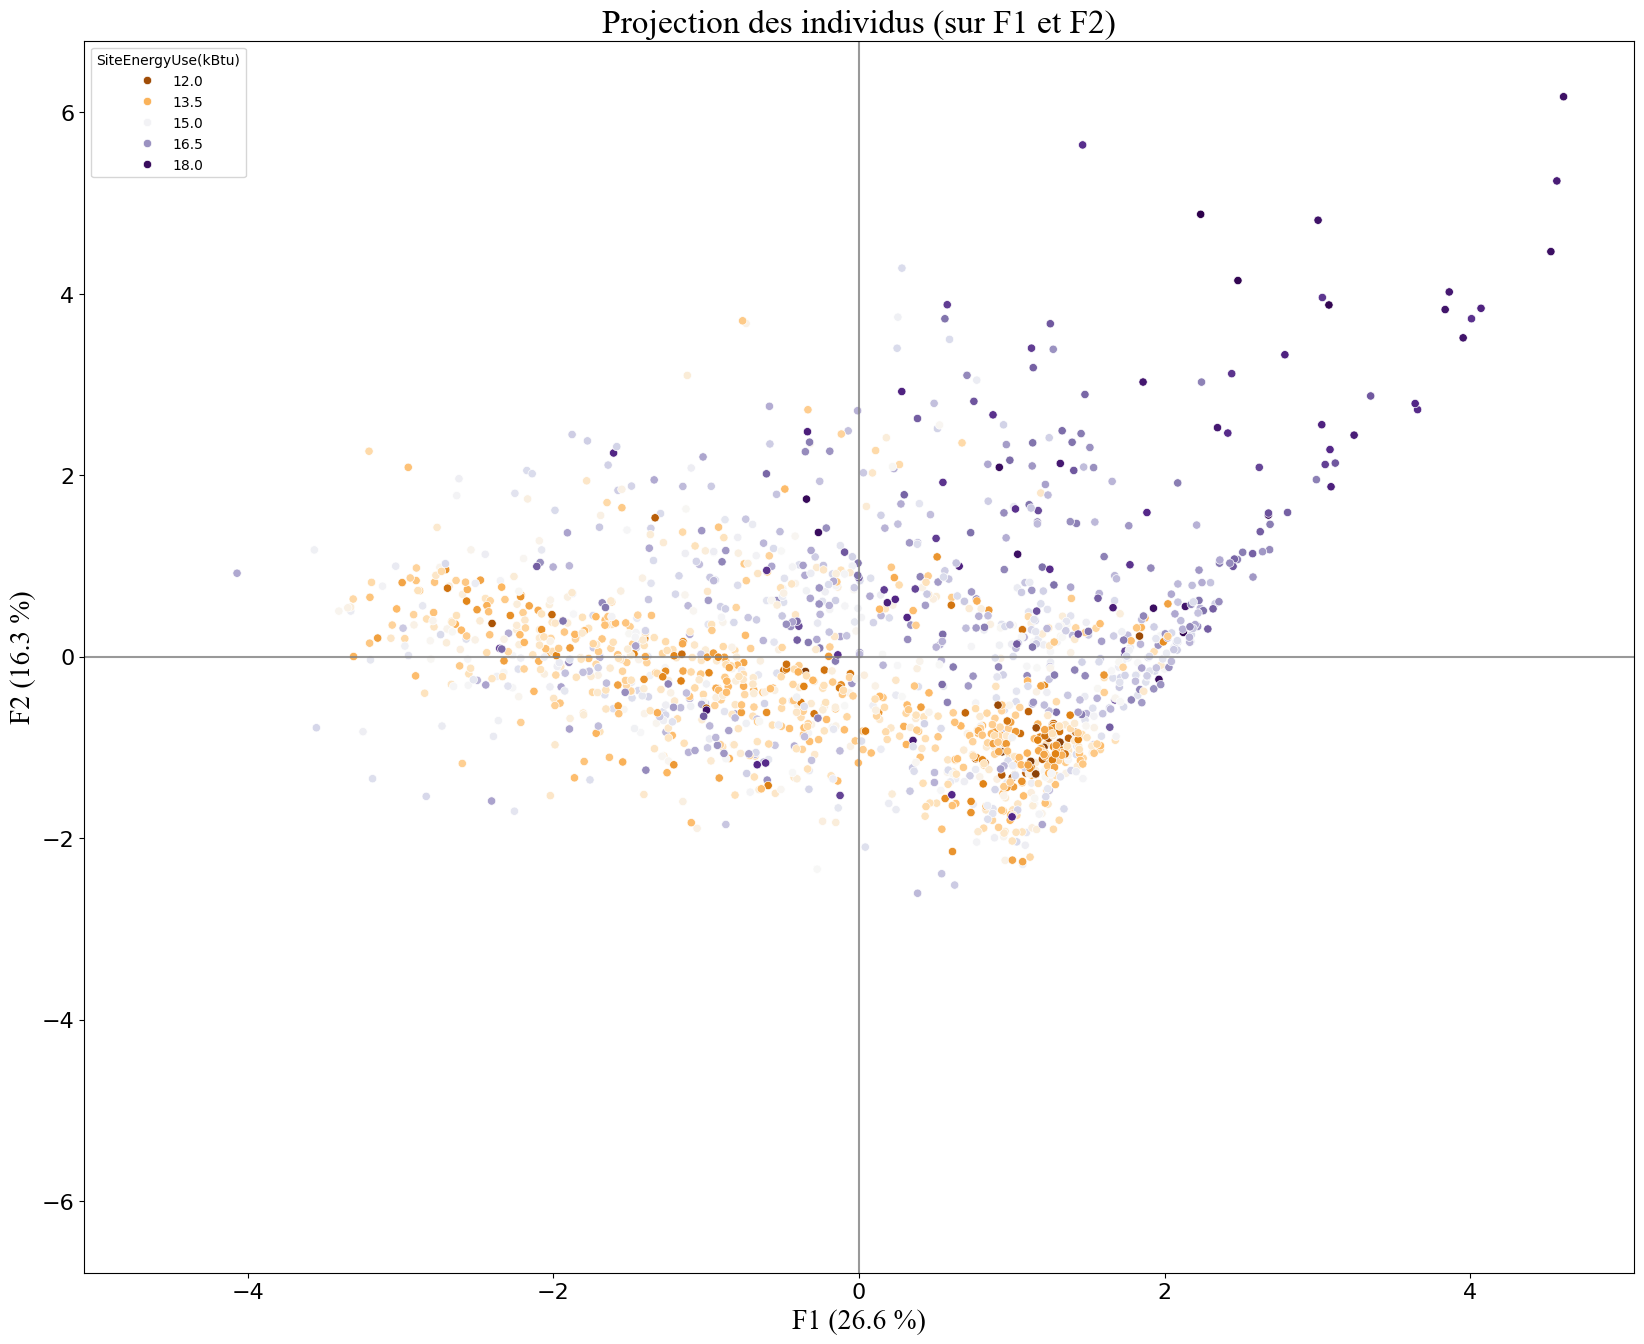

In [390]:
# Plan factoriel composante 1 et 2 
x_y = [0, 1]
plan_factoriel(X_proj, x_y, acp_retenue, figsize=(20,16), clusters=df_data_clean_corr['SiteEnergyUse(kBtu)'], marker="o")

##### TotalGHGEmissions
Plan factoriel et cercle de corrélation F1 et F2

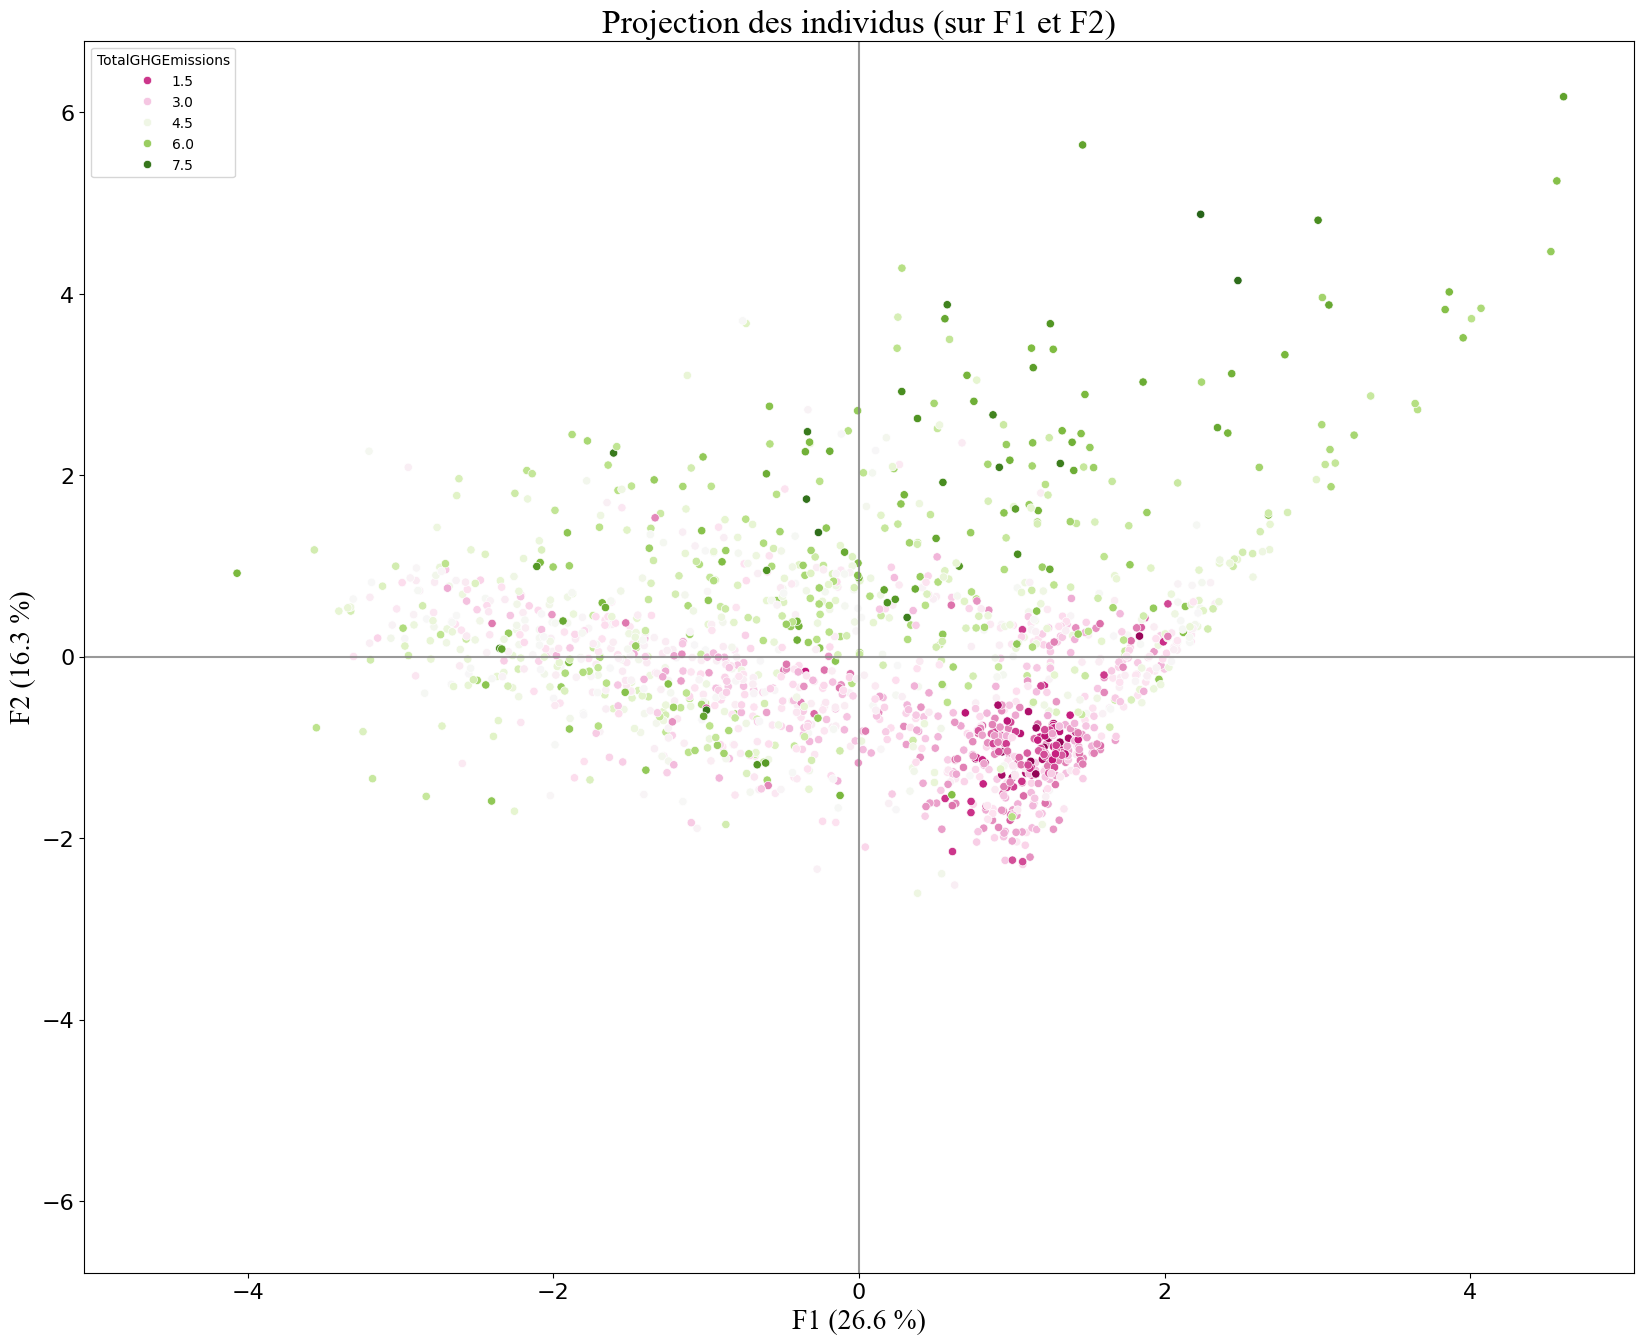

In [391]:
# Plan factoriel composante 1 et 2 
x_y = [0, 1]
plan_factoriel(X_proj, x_y, acp_retenue, figsize=(20,16), clusters=df_data_clean_corr['TotalGHGEmissions'], marker="o", palette="PiYG")

#### <span style='background:white; color:black'>Cercle des corrélations</span>

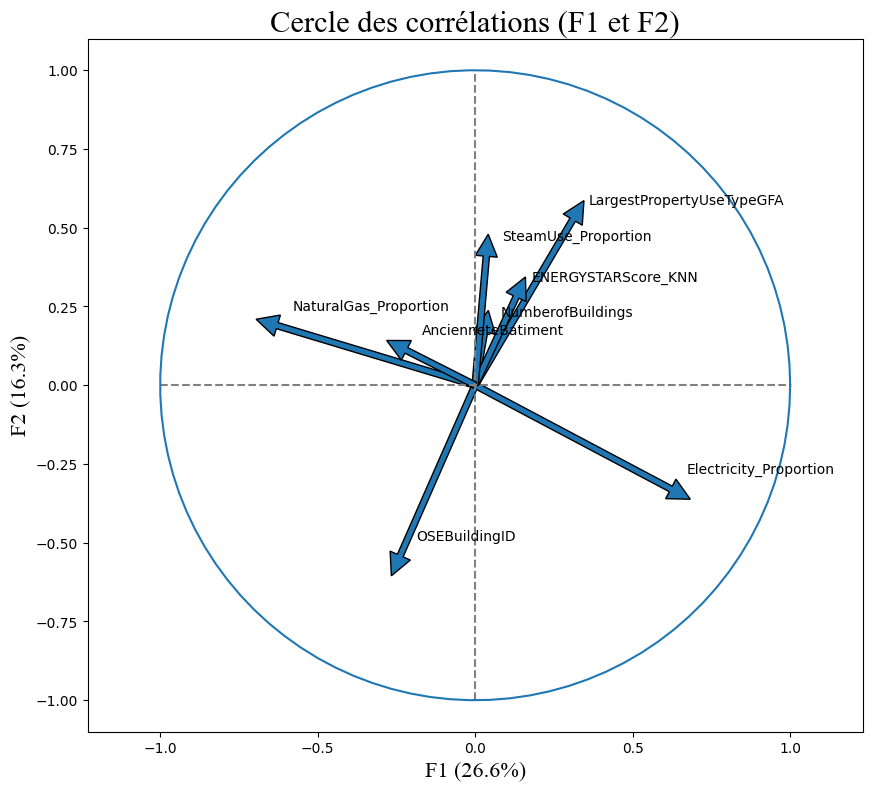

In [392]:
# Cercle des corrélations des composantes 1 et 2
cercle_correlation(acp_retenue, (0, 1), features)

Nous remarquons que la 1ère composante principale (F1) semble corrélée à la proportion d'énergie provenant de l'électricité. Elle est également corrélée négativement à la proportion d'énergie provenant du gaz naturel. 

**F1 semble corrélé à la propreté énergétique du bâtiment (en termes d'émission de CO2)**.
<br><br>

La 2ème composante principale (F2) semble corrélée à la surface dédiée à l'usage principal du bâtiment et à la proportion d'énergie provenant de la vapeur. Elle est aussi corrélée négativement au numéro d'identification.

**F2 semble corrélé à la taille du bâtiment. Manifestement, plus les bâtiments sont grands et plus ils utilisent la vapeur comme source d'énergie. Egalement, il y aurait davantage de grands bâtiments parmi les premiers à avoir été audités par les agents municipaux**.
<br><br>

La 3ème composante principale (F3) semble corrélée négativement à l'ancienneté du bâtiment et à la proportion de l'énergie provenant de la vapeur.

**F3 semble corrélé à la récence du bâtiment. Manifestement, les bâtiments anciens favorisent davantage la vapeur comme source d'énergie**.
<br><br>

La 4ème composante principale (F4) semble corrélée négativement à l'ENERGY STAR Score du bâtiment. Elle est également corrélée positivement au nombre de bâtiments séparés.

**F4 semble corrélé à l'inefficacité énergétique du bâtiment. Manifestement, cette innefficacité énergétique va de pair avec le nombre de bâtiments séparés**.
<br><br>

# <span style='background:blue'>Etape 4 : Exportation du dataset nettoyé</span>
___

Le dataset final que nous allons exporter est celui qui a été nettoyé des features corrélées et des multicollinéarisées.
Ce dataset contient les 2 features cibles et la feature d'ENERGYSTARScore incomplet (sans les valeurs imputées par KNN).

In [393]:
# Dataframe finale après nettoyage
df_data_clean_final = df_data_clean_corr.drop(columns=["Longitude", "Latitude"])

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_final, "df_data_clean_final", "des features corrélées et multicollinéarisées", 3)

Voici l'aspect de 'df_data_clean_final' après nettoyage des features corrélées et multicollinéarisées


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
0,1,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1.0,Hotel,88434.0,60.0,60.0,15.79325,False,Compliant,5.52537,0.54606,0.27730,0.17664,89
1,2,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1.0,Hotel,83880.0,61.0,61.0,15.94230,False,Compliant,5.69326,0.38661,0.00000,0.61339,20
2,3,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,1.0,Hotel,756493.0,43.0,43.0,18.10030,False,Compliant,7.64505,0.68231,0.29711,0.02058,47


1610 ligne(s) x 18 colonne(s)




Nous allons sauvegarder le dataset nettoyé (celui qui contient ) pour l'utiliser dans nos modèles de machine learning.

In [394]:
# Chemin du dossier et nom du fichier de l'export nettoyé
output_directory = "data/cleaned"
nomFichier_export = "2016_Building_Energy_Benchmarking_cleaned.csv"

# Vérification de l'existence du dossier
os.makedirs(output_directory, exist_ok=True)

# Chemin complet du fichier export
output_file = os.path.join(output_directory, nomFichier_export)

# export df nettoyé en CSV (tabulation en séparateur)
df_data_clean_final.set_index("OSEBuildingID").to_csv(output_file, sep='\t', encoding='utf-8', index=False)

# <span style='background:blue'>Conclusion</span>

Les données de ce dataset ont été nettoyées de ses features inutiles ou redondantes, des batiments non-utiles pour nos analyses et des outliers. Les valeurs manquantes ont été imputées par des algorithmes de machine learning de type KNN.

L'analyse exploratoire nous apprend que plus des 3/4 des batiments sont des bâtiments non résidentiels (notamment des bureaux et des entrepôts non-réfrigérés), ainsi que l'électricité est la source d'énergie la plus utilisée pour la consommation d'énergie.

Nous avons identifié les 2 features cibles, à savoir :
- Emission de CO2 : '**TotalGHGEmissions**' exprimé en tonnes métriques d'équivalent de dioxyde de carbone (tCO2e)
- Consommation totale d’énergie : '**SiteEnergyUse(kBtu)**' exprimé en kBtu (unité thermique britannique)

Ces 2 features cibles présentent une corrélation linéaire forte entre elles (R = 0,88). 

Une ACP nous a permis de déterminer les 4 composantes principales qui expliquent plus de 70% de l'inertie totale. Il semblerait que la propreté énergétique et la taille des bâtiments soient les 2 facteurs les plus importants pour prédire la consommation d'énergie et les émissions de CO2 des bâtiments de la ville de Seattle.

**Le dataset nettoyé est prêt à être utilisé pour la réalisation de modèles de machine learning dans les 2 autres notebooks du projet.**

In [395]:
# Calculer et afficher la durée totale
total_time = time.time() - start_time

# Convertir en minutes et secondes
minutes, seconds = divmod(total_time, 60)

# Afficher la durée totale
print("Durée totale pour faire tourner le notebook : {0} minute(s) {1} seconde(s)".format(int(minutes), int(seconds)))

Durée totale pour faire tourner le notebook : 0 minute(s) 16 seconde(s)
